In [2]:
import urllib.request
import requests
from bs4 import BeautifulSoup
import pandas as pd
import multiprocessing
import gensim
import sys
import seaborn as sns
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from scipy import spatial
from collections import Counter
import numpy as np
from collections import defaultdict
from pprint import pprint
from gensim import corpora
import re
import logging
from glob import glob
import statsmodels.api as sm
import scipy
import scipy.stats as ss
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import metrics
from sklearn.cluster import KMeans
# from the demo
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/xuhuimin/anaconda3/lib/

In [3]:
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()
    
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def cultureD2(model, words):
    cultures = []
    for word in words:
        if (word[0] in model.wv.vocab) & (word[1] in model.wv.vocab):
            cultures.append(normalize(model[word[0]] - model[word[1]]))
        else:
            print(word)
    culturev = normalize(np.mean(cultures, axis=0))
    return culturev

def storyv(model,words):
    veclist=[]
    for w in words:
        if w in model.wv.vocab:
            veclist.append(model[w])
    storyv=normalize(np.mean(veclist,axis=0))
    return storyv

def projection(storyv, culturev):
    # cosine similarity
    return (1 - spatial.distance.cosine(storyv, culturev))

def avglead(model,results):
    leadlist=[]
    veclist=[]
    for i in range(100):
        leadlist.append(results[i][0])
    for w in leadlist:
        if w in model.wv.vocab:
            veclist.append(model[w])
    avgv=normalize(np.mean(veclist,axis=0)) 
    return avgv
           
def cosine2angle(i):
    return np.arccos(i) / np.pi * 180 #长度换角度

def normalized(x):
    x= np.array(x)
    return (x-np.mean(x))/np.std(x)

swords = [
    ['success','failure'],
    ['succeed','fail'],
    ['lucky', 'unlucky'],
    ['fortunate', 'unfortunate'],
    ['happy', 'unhappy'],
    ['glad', 'sad'],
    ['joy', 'sorrow'],
    ['smile', 'tear']
] # success words

In [4]:
with open('./male.txt') as f:
    male_names_list = [i.strip('\n').lower() for i in f.readlines()]
    
with open('./female.txt') as f:
    female_names_list = [i.strip('\n').lower() for i in f.readlines()]

In [4]:
# Load Google's pre-trained Word2Vec model.
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

model = gensim.models.KeyedVectors.load_word2vec_format('english_fiction_sgns_gensim_1990.txt')

2018-10-21 17:49:37,683 : INFO : loading projection weights from english_fiction_sgns_gensim_1990.txt
2018-10-21 17:49:57,596 : INFO : loaded (100000, 300) matrix from english_fiction_sgns_gensim_1990.txt


In [5]:
success_vector = cultureD2(model, swords)
success_word = [i[0] for i in model.similar_by_vector(success_vector, 1)]

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app
2018-10-21 17:50:18,811 : INFO : precomputing L2-norms of word weight vectors
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/gensim/models/keyedvectors.py:1048: RuntimeWarning: invalid value encountered in true_divide
  self.vectors_norm = (self.vectors / sqrt((self.vectors ** 2).sum(-1))[..., newaxis]).astype(REAL)


In [6]:
len(success_vector)

300

In [7]:
success_word

['lucky']

In [5]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

### word2vec

In [19]:
film_script_list=["Cinderella was a lovely girl",
"Her old mother died",
"Her father married a wife", 
"and the stepmother has brought two elder sisters",
"She does a lot of housework everyday",
"So the girl's clothes were very dirty",
"Everybody called her Cinderella",
"The prince gave all the females an invitation", 
"asked them to come in the palace to join the dance party", 
"But Cinderella’s stepmother didn’t let her go",
"The day of the party arrived. Cinderella met a fairy godmother",
"She gave Cinderella a coach, two shoots, two horses and a beautiful dress",
"But magic will stop working at midnight",
"Cinderella arrived at the palace and walked into the dance hall", 
"The Prince saw her. He danced only with Cinderella, and he fell in love with her.",
"A clock chiming reminded Cinderella of her fairy godmother's warning",
"She ran out of the palace. The Prince only found Cinderella’s one glass shoot",
"The next morning, The Prince proclaimed: Whoever the shoot fits, shall be wife to him",
"He arrived at the stepmother's house.",
"And Cinderella’s sisters can’t fit the shoot. But she can.",
"Then Cinderella took the other shoot from her pocket and put it on",
"Finally, the Prince and Cinderella were married. They lived happily ever after"]

In [20]:
film_script_str = ','.join(film_script_list)
tknzr = WordPunctTokenizer()
corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
corpus = [i for i in corpus if i != []]
corpus=corpus[0]

n_split = 10
corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


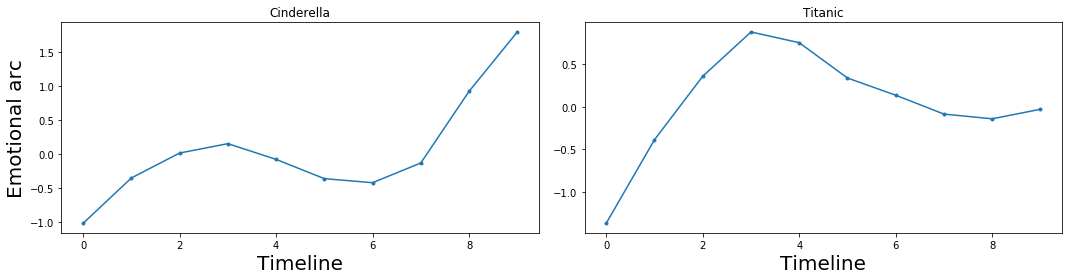

In [21]:
fig = plt.figure(figsize=(15,4))
ax=fig.add_subplot(121)

film_script_str = ','.join(film_script_list)
tknzr = WordPunctTokenizer()
corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
corpus = [i for i in corpus if i != []]
corpus=corpus[0]
n_split = 10
corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]
anglesi = []
for n in range (n_split):
    wordlist=corpus[n]
    story_vector=storyv(model,wordlist)
#     anglesi.append(projection(story_vector,success_vector)) #相似性
    anglesi.append(90-cosine2angle(projection(story_vector,success_vector))) #长度换角度  
anglesi=normalized(anglesi)
exa = np.array(anglesi)
exa = savitzky_golay(exa, 11, 3) # window size 51, polynomial order 3
p30 = np.poly1d(np.polyfit(range(len(anglesi)),exa, 3))

plt.plot(range(len(anglesi)),exa,'.-',label='smooth')
plt.title('Cinderella')
plt.ylabel('Emotional arc',size=20)
plt.xlabel('Timeline',size=20)

# ax=fig.add_subplot(132)
# with open('/Users/xuhuimin/storytelling/imsdb/Shawshank-Redemption,-The.txt') as f:
#     film_script_list = f.readlines()
# film_script_str = ''.join(film_script_list)

# tknzr = WordPunctTokenizer()
# corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
# corpus = [i for i in corpus if i != []]

# n_split = 10
# corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

# anglesi = []
# for n in range (n_split):
#     wordlist=[]
#     for i in range(len(corpus[n])):
#         wordlist.extend(corpus[n][i])
#     story_vector=storyv(model,wordlist)
#     story_word = [i[0] for i in model.similar_by_vector(story_vector, 1)]
#     anglesi.append(90-cosine2angle(projection(story_vector,success_vector)))       
# anglesi=normalized(anglesi)
# exa = np.array(anglesi)
# exa = savitzky_golay(exa, 11, 3) # window size 51, polynomial order 3
# p30 = np.poly1d(np.polyfit(range(len(anglesi)),exa, 3))

# plt.plot(range(len(anglesi)),exa,'.-',label='smooth')
# plt.title('Shawshank Redemption')
# plt.xlabel('Timeline',size=20)

ax=fig.add_subplot(122)
with open('/Users/xuhuimin/storytelling/imsdb/Titanic.txt') as f:
    film_script_list = f.readlines()
film_script_str = ''.join(film_script_list)

tknzr = WordPunctTokenizer()
corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
corpus = [i for i in corpus if i != []]

n_split = 10
corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

anglesi = []
for n in range (n_split):
    wordlist=[]
    for i in range(len(corpus[n])):
        wordlist.extend(corpus[n][i])
    story_vector=storyv(model,wordlist)
    story_word = [i[0] for i in model.similar_by_vector(story_vector, 1)]

    anglesi.append(90-cosine2angle(projection(story_vector,success_vector)))
anglesi=normalized(anglesi)
exa = np.array(anglesi)
exa = savitzky_golay(exa, 11, 3) # window size 51, polynomial order 3
p30 = np.poly1d(np.polyfit(range(len(anglesi)),exa, 3))

plt.plot(range(len(anglesi)),exa,'.-',label='smooth')
plt.title('Titanic')
plt.xlabel('Timeline',size=20)
# plt.plot(range(len(anglesi)),anglesi,label='original')
# if p30[1] > 0:
#     plt.plot(range(len(anglesi)), p30(range(len(anglesi))), '-', color='r', alpha=0.3,label='fit')
# else:
#     plt.plot(range(len(anglesi)), p30(range(len(anglesi))), '-', color='g', alpha=0.3,label='fit')

# plt.legend()

plt.savefig('./picture/case.png', dpi=200)
plt.tight_layout()
plt.show()

### storytelling1

#### case

In [28]:
with open('/Users/xuhuimin/storytelling/imsdb/Shawshank-Redemption,-The.txt') as f:
    film_script_list = f.readlines()
film_script_str = ''.join(film_script_list)

tknzr = WordPunctTokenizer()
corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
corpus = [i for i in corpus if i != []]

n_split = 10
corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

film_script_wordlist = tknzr.tokenize(film_script_str.lower())

film_name_list = (set(film_script_wordlist) & set(male_names_list)) |\
                    (set(film_script_wordlist) & set(female_names_list))
film_script_wordlist_counter = Counter(film_script_wordlist)
film_name_count_df = pd.DataFrame([[i, film_script_wordlist_counter[i]]for i in film_name_list]\
                                  , columns=['name', 'count'])
lead = film_name_count_df.sort_values(by='count', ascending=False)['name'].values[0]

In [32]:
anglesi = []
for j in range(n_split):
    modell=Word2Vec()
    modell.build_vocab(corpus[j])
    modell.train(corpus[j],total_examples=2,epochs=1)
    modell.save('./word2vec.model')
    modell=gensim.models.Word2Vec.load('./word2vec.model')
    results=modell.most_similar(lead,topn=100)

    lead_vector=avglead(model,results)
    lead_word = [i[0] for i in model.similar_by_vector(lead_vector, 1)]
    #     print(i,lead_word)

    anglesi.append(90 - cosine2angle(projection(model[lead_word], model[success_word])))

2018-08-08 17:24:07,432 : INFO : collecting all words and their counts
2018-08-08 17:24:07,434 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-08 17:24:07,436 : INFO : collected 1080 word types from a corpus of 3676 raw words and 475 sentences
2018-08-08 17:24:07,437 : INFO : Loading a fresh vocabulary
2018-08-08 17:24:07,439 : INFO : min_count=5 retains 119 unique words (11% of original 1080, drops 961)
2018-08-08 17:24:07,441 : INFO : min_count=5 leaves 2314 word corpus (62% of original 3676, drops 1362)
2018-08-08 17:24:07,443 : INFO : deleting the raw counts dictionary of 1080 items
2018-08-08 17:24:07,444 : INFO : sample=0.001 downsamples 84 most-common words
2018-08-08 17:24:07,446 : INFO : downsampling leaves estimated 941 word corpus (40.7% of prior 2314)
2018-08-08 17:24:07,448 : INFO : estimated required memory for 119 words and 100 dimensions: 154700 bytes
2018-08-08 17:24:07,449 : INFO : resetting layer weights
2018-08-08 17:24:07,452 : IN

2018-08-08 17:24:07,629 : INFO : saved ./word2vec.model
2018-08-08 17:24:07,630 : INFO : loading Word2Vec object from ./word2vec.model
2018-08-08 17:24:07,635 : INFO : loading wv recursively from ./word2vec.model.wv.* with mmap=None
2018-08-08 17:24:07,636 : INFO : setting ignored attribute vectors_norm to None
2018-08-08 17:24:07,638 : INFO : loading vocabulary recursively from ./word2vec.model.vocabulary.* with mmap=None
2018-08-08 17:24:07,640 : INFO : loading trainables recursively from ./word2vec.model.trainables.* with mmap=None
2018-08-08 17:24:07,641 : INFO : setting ignored attribute cum_table to None
2018-08-08 17:24:07,643 : INFO : loaded ./word2vec.model
2018-08-08 17:24:07,645 : INFO : precomputing L2-norms of word weight vectors
2018-08-08 17:24:07,662 : INFO : collecting all words and their counts
2018-08-08 17:24:07,665 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-08 17:24:07,668 : INFO : collected 1009 word types from a corpus of 3

2018-08-08 17:24:07,888 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-08-08 17:24:07,890 : INFO : saving Word2Vec object under ./word2vec.model, separately None
2018-08-08 17:24:07,894 : INFO : not storing attribute vectors_norm
2018-08-08 17:24:07,897 : INFO : not storing attribute cum_table
2018-08-08 17:24:07,901 : INFO : saved ./word2vec.model
2018-08-08 17:24:07,903 : INFO : loading Word2Vec object from ./word2vec.model
2018-08-08 17:24:07,906 : INFO : loading wv recursively from ./word2vec.model.wv.* with mmap=None
2018-08-08 17:24:07,909 : INFO : setting ignored attribute vectors_norm to None
2018-08-08 17:24:07,911 : INFO : loading vocabulary recursively from ./word2vec.model.vocabulary.* with mmap=None
2018-08-08 17:24:07,913 : INFO : loading trainables recursively from ./word2vec.model.trainables.* with mmap=None
2018-08-08 17:24:07,916 : INFO : setting ignored attribute cum_table to None
2018-08-08 17:24:07,918 :

2018-08-08 17:24:08,141 : INFO : EPOCH - 1 : training on 4382 raw words (1226 effective words) took 0.0s, 188199 effective words/s
2018-08-08 17:24:08,144 : WARNING : EPOCH - 1 : supplied example count (476) did not equal expected count (2)
2018-08-08 17:24:08,145 : INFO : training on a 4382 raw words (1226 effective words) took 0.0s, 97673 effective words/s
2018-08-08 17:24:08,147 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-08-08 17:24:08,149 : INFO : saving Word2Vec object under ./word2vec.model, separately None
2018-08-08 17:24:08,151 : INFO : not storing attribute vectors_norm
2018-08-08 17:24:08,153 : INFO : not storing attribute cum_table
2018-08-08 17:24:08,156 : INFO : saved ./word2vec.model
2018-08-08 17:24:08,158 : INFO : loading Word2Vec object from ./word2vec.model
2018-08-08 17:24:08,162 : INFO : loading wv recursively from ./word2vec.model.wv.* with mmap=None
2018-08-08 17:24:08,165 : INFO : setting ignored 

In [33]:
anglesi

[10.991469650366682,
 13.08735227105251,
 13.08735227105251,
 9.817244622247998,
 10.991469650366682,
 9.783994094305996,
 10.991469650366682,
 10.991469650366682,
 9.817244622247998,
 13.499752357752413]

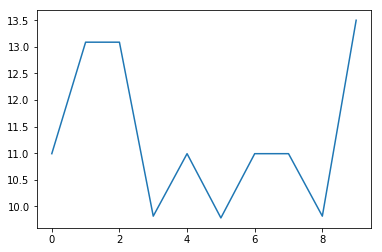

In [34]:
plt.plot(range(n_split),anglesi)

#### visualize

In [ ]:
angles = []

n_split = 3
count = 0
from nltk.tokenize import WordPunctTokenizer
tknzr = WordPunctTokenizer()

topmovie_list = ['Forrest-Gump', 'Inception', 'Schindler\'s-List', 'Pulp-Fiction', 'Godfather', 'Shawshank-Redemption,-The']

for file in glob('./imsdb/*')[:200]:
# for movie in topmovie_list:
#     file = './imsdb/' + movie + '.txt'
    flushPrint(count)
    
    with open(file) as f:
        film_script_list = f.readlines()
    film_script_str = ''.join(film_script_list)

    corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
    corpus = [i for i in corpus if i != []]
    corpus = [np.array(corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)]) for i in range(n_split)]

    film_script_wordlist = tknzr.tokenize(film_script_str.lower())

    film_name_list = (set(film_script_wordlist) & set(male_names_list)) |\
                        (set(film_script_wordlist) & set(female_names_list))
    film_script_wordlist_counter = Counter(film_script_wordlist)
    film_name_count_df = pd.DataFrame([[i, film_script_wordlist_counter[i]]for i in film_name_list]\
                                      , columns=['name', 'count'])
    lead = film_name_count_df.sort_values(by='count', ascending=False)['name'].values[0]

    for i in success_words:
        condition = 0
        for j in range(n_split):
            if i in {item for sublist in corpus[j] for item in sublist}:
                condition += 1 
        if condition == n_split:
            success_word = i
            break

    anglesi = []
    try:
        for corpus_line in corpus:
            model = Word2Vec(corpus_line, size=300, window=10, min_count=1, sample=1,
                        workers=multiprocessing.cpu_count(), hs=1, negative=0) # negative sampling, hs: hierarchical softmax
            anglesi.append(90 - cosine2angle(projection(model[lead], model[success_word])))
    except Exception as e:
        print(e)
        print(file, 'wrong')
        pass

    if lead in male_names_list:
        angles.append([anglesi, file, lead, 'male'])
    else:
        angles.append([anglesi, file, lead, 'female'])
    count += 1

In [ ]:
from glob import glob
angles = []

n_split = 3
count = 0
from nltk.tokenize import WordPunctTokenizer
tknzr = WordPunctTokenizer()

topmovie_list = ['Forrest-Gump', 'Inception', 'Schindler\'s-List', 'Pulp-Fiction', 'Godfather', 'Shawshank-Redemption,-The']

for file in glob('./imsdb/*')[:200]:
# for movie in topmovie_list:
#     file = './imsdb/' + movie + '.txt'
    flushPrint(count)
    
    with open(file) as f:
        film_script_list = f.readlines()
    film_script_str = ''.join(film_script_list)

    corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
    corpus = [i for i in corpus if i != []]
    corpus = [np.array(corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)]) for i in range(n_split)]

    film_script_wordlist = tknzr.tokenize(film_script_str.lower())

    film_name_list = (set(film_script_wordlist) & set(male_names_list)) |\
                        (set(film_script_wordlist) & set(female_names_list))
    film_script_wordlist_counter = Counter(film_script_wordlist)
    film_name_count_df = pd.DataFrame([[i, film_script_wordlist_counter[i]]for i in film_name_list]\
                                      , columns=['name', 'count'])
    lead = film_name_count_df.sort_values(by='count', ascending=False)['name'].values[0]

    for i in success_words:
        condition = 0
        for j in range(n_split):
            if i in {item for sublist in corpus[j] for item in sublist}:
                condition += 1 
        if condition == n_split:
            success_word = i
            break

    anglesi = []
    try:
        for corpus_line in corpus:
            model = Word2Vec(corpus_line, size=300, window=10, min_count=1, sample=1,
                        workers=multiprocessing.cpu_count(), hs=1, negative=0) # negative sampling, hs: hierarchical softmax
            anglesi.append(90 - cosine2angle(projection(model[lead], model[success_word])))
    except Exception as e:
        print(e)
        print(file, 'wrong')
        pass

    if lead in male_names_list:
        angles.append([anglesi, file, lead, 'male'])
    else:
        angles.append([anglesi, file, lead, 'female'])
    count += 1

In [ ]:
model = Word2Vec.load("word2vec.model")
model.train([["hello", "world"]], total_examples=1, epochs=1)
(0, 2)

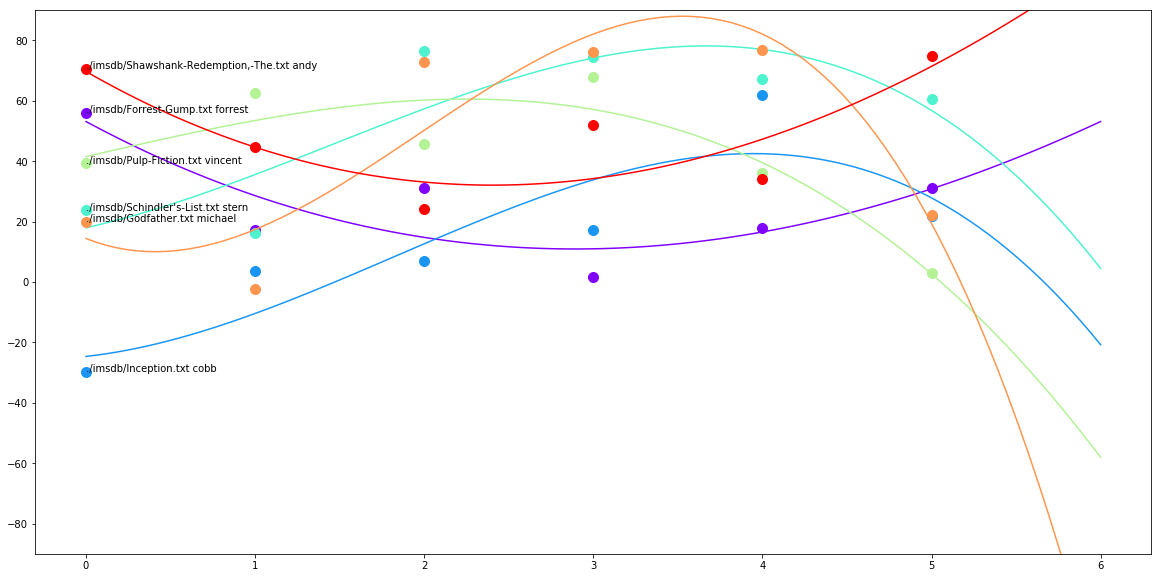

In [216]:
plt.figure(figsize=(20,10))
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]
for i in angles:
#     print(i[0])
    x = np.array(np.arange(n_split))
    y = np.array(i[0])
    plt.plot(x,y,'o', color=colors[angles.index(i)], markersize=10, alpha=0.3)
    xp = np.linspace(0, n_split, 100)
    p30 = np.poly1d(np.polyfit(x, y, 3))
    plt.plot(xp, p30(xp), '-', color=colors[angles.index(i)])
    plt.text(0, i[0][0], i[1]+' '+i[2])
    plt.ylim(-90,90)


In [226]:
i

[[], './imsdb/Gamer.txt', 'simon']

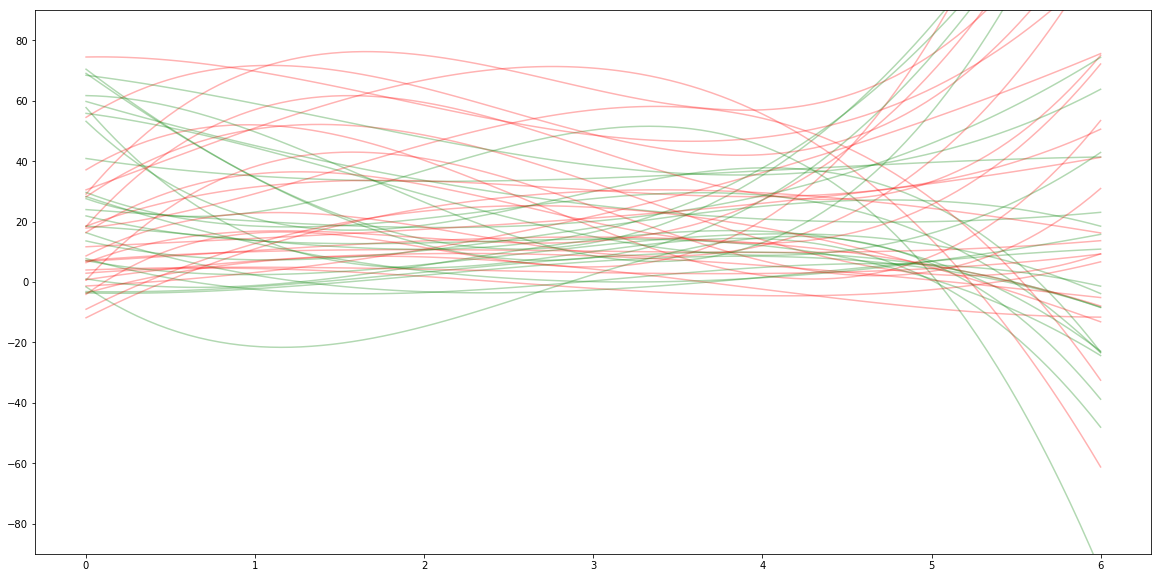

In [233]:
plt.figure(figsize=(20,10))
cmap = plt.get_cmap('rainbow')
colors = 'grey'
for i in angles:
    if i[0] != []:
    #     print(i[0])
        x = np.array(np.arange(n_split))
        y = np.array(i[0])
#         plt.plot(x,y,'o', color='g', markersize=10, alpha=0.3)
        xp = np.linspace(0, n_split, 100)
        p30 = np.poly1d(np.polyfit(x, y, 3))
        if p30[1] > 0:
            plt.plot(xp, p30(xp), '-', color='r', alpha=0.3)
        else:
            plt.plot(xp, p30(xp), '-', color='g', alpha=0.3)
    #     plt.text(0, i[0][0], i[1]+' '+i[2])
        plt.ylim(-90,90)


In [295]:
x,y

(array([0, 1, 2]), array([74.43162171, 18.00580698]))

(80, 90)

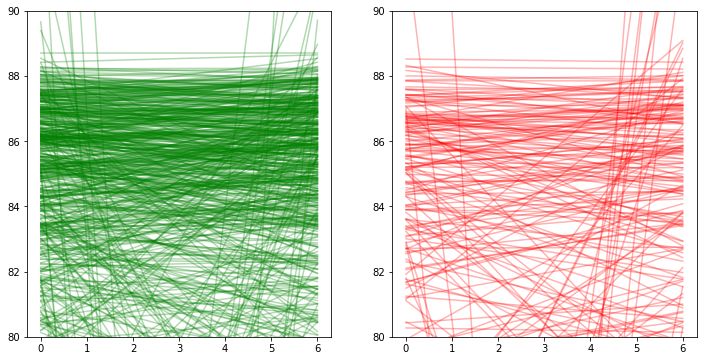

In [342]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
male_upcount = 0
female_upcount = 0
male_downcount = 0
female_downcount = 0
for i in angles:
    # print(i)
    if i[0] != []:
        if len(i[0]) == 6:
            
    #     print(i[0])
            x = np.array(np.arange(n_split))
            y = np.array(i[0])
    #         plt.plot(x,y,'o', color='g', markersize=10, alpha=0.3)
            xp = np.linspace(0, n_split, 100)
            p30 = np.poly1d(np.polyfit(x, y, 1))
            a = np.polyfit(x, y, 1)[0]
            
            if i[3] == 'male':
                if a > 0:
                    male_upcount += 1
                    ax1.plot(xp, p30(xp), '-', color='g', alpha=0.3)
                else:
                    male_downcount += 1
                    ax1.plot(xp, p30(xp), '-', color='g', alpha=0.3)
            else:
                if a > 0:
                    female_upcount += 1
                    ax2.plot(xp, p30(xp), '-', color='r', alpha=0.3)
                else:
                    female_downcount += 1
                    ax2.plot(xp, p30(xp), '-', color='r', alpha=0.3)
            
ax1.set_ylim(80,90)
ax2.set_ylim(80,90)
# ax1.set_xlim(-90,90)
# ax2.set_xlim(-90,90)

In [343]:
print(male_upcount / (male_upcount + male_downcount), (male_upcount), male_downcount)
print(female_upcount / (female_upcount + female_downcount), (female_upcount), female_downcount)

0.46102150537634407 343 401
0.5021459227467812 117 116


In [341]:
from glob import glob
angles = []

n_split = 6
count = 0
from nltk.tokenize import WordPunctTokenizer
tknzr = WordPunctTokenizer()

topmovie_list = ['Forrest-Gump', 'Inception', 'Schindler\'s-List', 'Pulp-Fiction', 'Godfather', 'Shawshank-Redemption,-The']

for file in glob('./imsdb/*')[:1000]:
# for movie in topmovie_list:
#     file = './imsdb/' + movie + '.txt'

#     with open(glob('./imsdb/*')[0]) as f:
#         film_script_list = f.readlines()


    with open(file) as f:
        film_script_list = f.readlines()
#     film_script_str = ''.join(film_script_list)
    film_script_str = ''.join(film_script_list)
    corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
    corpus = [i for i in corpus if i != []]
    model = Word2Vec(corpus, size=300, window=10, min_count=1, sample=1,
                            workers=multiprocessing.cpu_count(), hs=1, negative=0) # negative sampling, hs: hierarchical softmax
    model.save("word2vec.model")

    flushPrint(count)
    
    with open(file) as f:
        film_script_list = f.readlines()
    film_script_str = ''.join(film_script_list)

    corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
    corpus = [i for i in corpus if i != []]
    corpus = [np.array(corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)]) for i in range(n_split)]

    film_script_wordlist = tknzr.tokenize(film_script_str.lower())

    film_name_list = (set(film_script_wordlist) & set(male_names_list)) |\
                        (set(film_script_wordlist) & set(female_names_list))
    film_script_wordlist_counter = Counter(film_script_wordlist)
    film_name_count_df = pd.DataFrame([[i, film_script_wordlist_counter[i]]for i in film_name_list]\
                                      , columns=['name', 'count'])
    lead = film_name_count_df.sort_values(by='count', ascending=False)['name'].values[0]

    for i in success_words:
        condition = 0
        for j in range(n_split):
            if i in {item for sublist in corpus[j] for item in sublist}:
                condition += 1 
        if condition == n_split:
            success_word = i
            break

    anglesi = []
    try:
        for corpus_line in corpus:
#             print(corpus_line)
            model = Word2Vec.load('./word2vec.model')
            model.train(corpus_line, total_examples=2, epochs=1)
            # print(model.wv.vocab)
            anglesi.append(90 - cosine2angle(projection(model[lead], model[success_word])))
    except Exception as e:
        print(e)
        print(file, 'wrong')
        pass

    if lead in male_names_list:
        angles.append([anglesi, file, lead, 'male'])
    else:
        angles.append([anglesi, file, lead, 'female'])
    count += 1

76"word 'good' not in vocabulary"
./imsdb/Sneakers.txt wrong
89"word 'we' not in vocabulary"
./imsdb/Shadow-of-the-Vampire.txt wrong
104"word 'smile' not in vocabulary"
./imsdb/Jeux-Interdits.txt wrong
118"word 'good' not in vocabulary"
./imsdb/Ni-vu-ni-connu.txt wrong
205"word 'smile' not in vocabulary"
./imsdb/Les-Tontons-Flingueurs.txt wrong
217"word 'thank' not in vocabulary"
./imsdb/Le-Diable-par-la-Queue.txt wrong
258"word 'good' not in vocabulary"
./imsdb/Apollo-13.txt wrong
309"word 'we' not in vocabulary"
./imsdb/Scary-Movie-2.txt wrong
327"word 'smile' not in vocabulary"
./imsdb/Jade.txt wrong
450"word 'smile' not in vocabulary"
./imsdb/Equilibrium.txt wrong
583"word 'few' not in vocabulary"
./imsdb/Officer-and-a-Gentleman,-An.txt wrong
655"word 'good' not in vocabulary"
./imsdb/Vertigo.txt wrong
675"word 'good' not in vocabulary"
./imsdb/When-Harry-Met-Sally.txt wrong
692"word 'smile' not in vocabulary"
./imsdb/Mr.-Holland's-Opus.txt wrong
751"word 'we' not in vocabulary"
./

In [307]:
help(model.train)

Help on method train in module gensim.models.word2vec:

train(sentences, total_examples=None, total_words=None, epochs=None, start_alpha=None, end_alpha=None, word_count=0, queue_factor=2, report_delay=1.0, compute_loss=None) method of gensim.models.word2vec.Word2Vec instance
    Update the model's neural weights from a sequence of sentences (can be a once-only generator stream).
    For Word2Vec, each sentence must be a list of unicode strings. (Subclasses may accept other examples.)
    
    To support linear learning-rate decay from (initial) alpha to min_alpha, and accurate
    progres-percentage logging, either total_examples (count of sentences) or total_words (count of
    raw words in sentences) MUST be provided. (If the corpus is the same as was provided to
    `build_vocab()`, the count of examples in that corpus will be available in the model's
    `corpus_count` property.)
    
    To avoid common mistakes around the model's ability to do multiple training passes itself, an

[0 1 2 3 4 5] [84.03385602 84.21503929 84.42103544 86.96365148 86.98409366 87.27947475]
[0 1 2 3 4 5] [87.90146209 87.99035776 86.94328184 85.01103738 86.05900988 84.79082655]
[0 1 2 3 4 5] [83.42409752 84.03063698 83.84820511 87.07503874 88.12132242 87.91521669]
[0 1 2 3 4 5] [87.25561963 87.75571582 85.77891062 84.1419427  84.59593275 81.17307446]


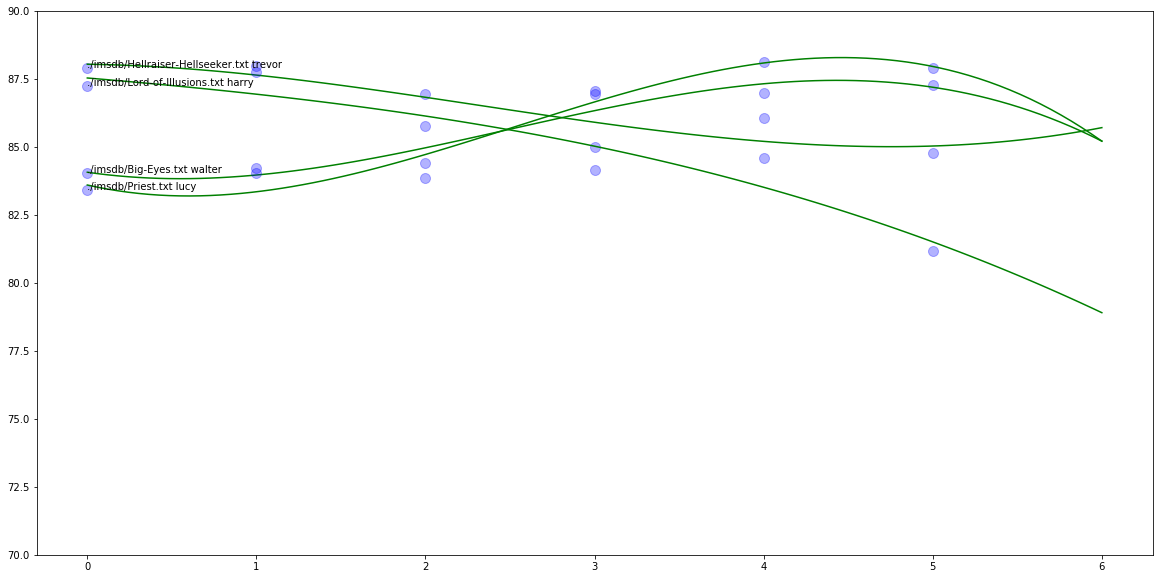

In [284]:
plt.figure(figsize=(20,10))
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]
for i in angles:
#     print(i[0])
    if i[0] != []:
        x = np.array(np.arange(n_split))
        y = np.array(i[0])
        print(x, y)
        plt.plot(x,y,'o', color='b', markersize=10, alpha=0.3)
        xp = np.linspace(0, n_split, 100)
        p30 = np.poly1d(np.polyfit(x, y, 3))
        plt.plot(xp, p30(xp), '-', color='g')
        plt.text(0, i[0][0], i[1]+' '+i[2])
        plt.ylim(70,90)


### storytelling2

#### case

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


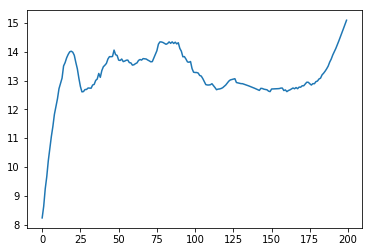

In [88]:
# with open('/Users/xuhuimin/storytelling/imsdb/Shawshank-Redemption,-The.txt') as f:
with open('/Users/xuhuimin/storytelling/imsdb/Titanic.txt') as f:
    film_script_list = f.readlines()
film_script_str = ''.join(film_script_list)

tknzr = WordPunctTokenizer()
corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
corpus = [i for i in corpus if i != []]

n_split = 200
corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

anglesi = []
for n in range (n_split):
    wordlist=[]
    for i in range(len(corpus[n])):
        wordlist.extend(corpus[n][i])
    story_vector=storyv(model,wordlist)
    story_word = [i[0] for i in model.similar_by_vector(story_vector, 1)]

    anglesi.append(90 - cosine2angle(projection(model[success_word], model[story_word])))        

exa = np.array(anglesi)
exa = savitzky_golay(exa, 51, 3) # window size 51, polynomial order 3
p30 = np.poly1d(np.polyfit(range(len(anglesi)),exa, 3))

plt.plot(range(len(anglesi)),exa,label='smooth')
# plt.plot(range(len(anglesi)),anglesi,label='original')
# if p30[1] > 0:
#     plt.plot(range(len(anglesi)), p30(range(len(anglesi))), '-', color='r', alpha=0.3,label='fit')
# else:
#     plt.plot(range(len(anglesi)), p30(range(len(anglesi))), '-', color='g', alpha=0.3,label='fit')

# plt.text(0.5,0.5,'Titanic')
# plt.legend()
plt.show()

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


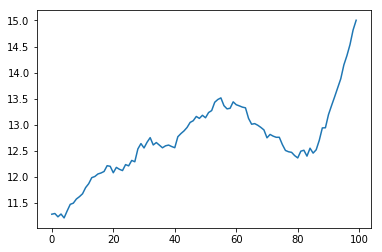

In [87]:
with open('/Users/xuhuimin/storytelling/imsdb/Shawshank-Redemption,-The.txt') as f:
# with open('/Users/xuhuimin/storytelling/imsdb/Titanic.txt') as f:
    film_script_list = f.readlines()
film_script_str = ''.join(film_script_list)

tknzr = WordPunctTokenizer()
corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
corpus = [i for i in corpus if i != []]

n_split = 100
corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

anglesi = []
for n in range (n_split):
    wordlist=[]
    for i in range(len(corpus[n])):
        wordlist.extend(corpus[n][i])
    story_vector=storyv(model,wordlist)
    story_word = [i[0] for i in model.similar_by_vector(story_vector, 1)]

    anglesi.append(90 - cosine2angle(projection(model[success_word], model[story_word])))        

exa = np.array(anglesi)
exa = savitzky_golay(exa, 51, 3) # window size 51, polynomial order 3
p30 = np.poly1d(np.polyfit(range(len(anglesi)),exa, 3))

plt.plot(range(len(anglesi)),exa,label='smooth')
# plt.plot(range(len(anglesi)),anglesi,label='original')
# if p30[1] > 0:
#     plt.plot(range(len(anglesi)), p30(range(len(anglesi))), '-', color='r', alpha=0.3,label='fit')
# else:
#     plt.plot(range(len(anglesi)), p30(range(len(anglesi))), '-', color='g', alpha=0.3,label='fit')

# plt.text(0.5,0.5,'Titanic')
# plt.legend()
plt.show()

#### visulization

In [123]:
angels=[]

files=glob('./imsdb/*')
for k in range(len(files)):
    flushPrint(k)
    with open(files[k]) as f:
        film_script_list = f.readlines()
    try:
        film_script_str = ''.join(film_script_list)

        tknzr = WordPunctTokenizer()
        corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
        corpus = [i for i in corpus if i != []]

        n_split = 100
        corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

        anglesi = []
        for n in range (n_split):
            wordlist=[]
            for i in range(len(corpus[n])):
                wordlist.extend(corpus[n][i])
            story_vector=storyv(model,wordlist)
            story_word = [i[0] for i in model.similar_by_vector(story_vector, 1)]

            anglesi.append(90 - cosine2angle(projection(model[success_word], model[story_word]))) 
        
        angels.append([files[k],anglesi])

    except Exception as e:
        print(e)
        print(files[k], 'wrong')
        pass

0

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


1'numpy.float64' object is not iterable
./imsdb/Speed.txt wrong
2

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19'numpy.float64' object is not iterable
./imsdb/Monster's-Ball.txt wrong
49

KeyboardInterrupt: 

In [ ]:
name=[i[0].split('/')[-1].split('.')[0] for i in angels]

vec=[i[1] for i in angels]

diction=dict(zip(name,vec))

In [74]:
movie_type=pd.read_csv('./movie_type.csv')
movie_type['wordvec100']=movie_type['name'].apply(lambda x: diction[x] if x in diction
                                          else np.nan)

In [76]:
movie_type.to_csv('./movie_type.csv')

In [6]:
movie_type=pd.read_csv('./movie_type.csv')

In [7]:
movie_type['wordvec100']=movie_type['wordvec100'].apply(lambda x: eval(x))

In [8]:
angels=movie_type[['name','wordvec100']].values

In [9]:
len(angels)

1109

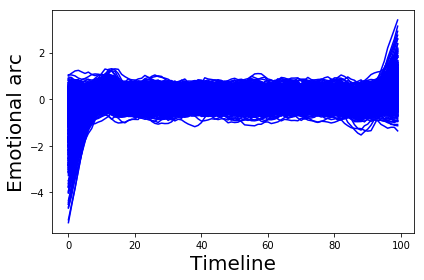

In [10]:
# 没有平滑
n_split=100
for i in angels:
    exa = np.array(i[1])
    exa = normalized(i[1])
    plt.plot(range(n_split),savitzky_golay(exa, 33, 3),color='b',label='smooth')

plt.ylabel('Emotional arc',size=20)
plt.xlabel('Timeline',size=20)
plt.savefig('./picture/nosmooth_100.png',dpi=200)
plt.tight_layout()
plt.show()

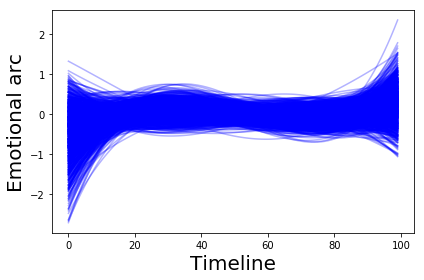

In [11]:
# 平滑
for i in angels:  
    exa = np.array(i[1])
    exa = normalized(exa)
    exa = savitzky_golay(exa, 33, 3)
    p30 = np.poly1d(np.polyfit(range(n_split),exa, 3))
    plt.plot(range(n_split), p30(range(len(exa))), '-', color='b', alpha=0.3)
plt.ylabel('Emotional arc',size=20)
plt.xlabel('Timeline',size=20)
plt.savefig('./picture/smooth_100.png',dpi=200)
plt.tight_layout()
plt.show()

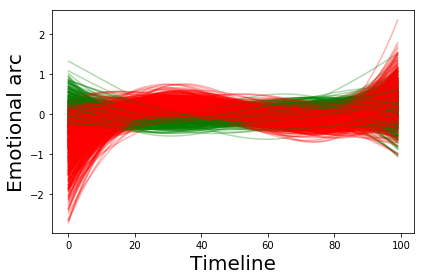

In [14]:
# with ending
up=[]
down=[]
for i in angels:  
    exa = np.array(i[1])
    exa = normalized(exa)
    exa = savitzky_golay(exa, 33, 3)
    p30 = np.poly1d(np.polyfit(range(n_split),exa, 3))
    if p30[1] > 0:
        up.append(i[0])
        plt.plot(range(n_split), p30(range(len(exa))), '-', color='r', alpha=0.3)
    else:
        down.append(i[0])
        plt.plot(range(n_split), p30(range(len(exa))), '-', color='g', alpha=0.3)

plt.ylabel('Emotional arc',size=20)
plt.xlabel('Timeline',size=20)
plt.savefig('./picture/ending_100.png',dpi=200)
plt.tight_layout()
plt.show()


In [63]:
def mean(x):
    x=np.array(x)
#     return(np.mean(x,axis=0),ss.sem(x,axis=0))
    return(np.mean(x,axis=0),np.std(x,axis=0))

In [64]:
ang=[]
for i in angels:
    exa = np.array(i[1])
    exa = normalized(exa)
    exa = savitzky_golay(exa, 33, 3)
#     p30 = np.poly1d(np.polyfit(range(n_split),exa, 3))
    ang.append(exa)
m,s=mean(ang)

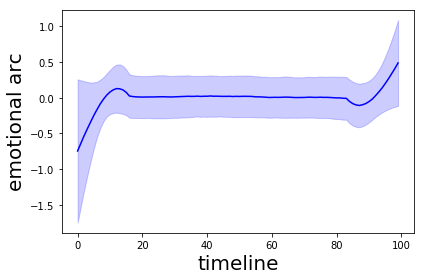

In [65]:
plt.plot(m,color='b')
plt.fill_between(range(100),np.array(m)-np.array(s),np.array(m)+np.array(s),alpha=0.2,color='b')
plt.ylabel('motional arc',size=20)
plt.xlabel('Timeline',size=20)
plt.tight_layout()
plt.savefig('./picture/endingmean_100.png',dpi=200)
plt.show()

In [123]:
len(up)

838

In [124]:
up=[u.split('/')[-1].split('.')[0] for u in up]

In [125]:
len(down)

271

In [126]:
down=[d.split('/')[-1].split('.')[0] for d in down]

In [133]:
movie_type=pd.read_csv('./movie_type.csv')

In [136]:
up_df=movie_type.loc[movie_type['name'].isin(up)].index

movie_type.ix[up_df,'ending_100']=0

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [137]:
down_df=movie_type.loc[movie_type['name'].isin(down)].index

movie_type.ix[down_df,'ending_100']=1

In [138]:
movie_type.to_csv('./movie_type.csv')

#### correlation

In [27]:
movie_type=pd.read_csv('./movie_type.csv',index_col=0)

In [28]:
data=movie_type[['User_rating','ending_100','gender']]

In [29]:
data=data.dropna(axis=0,how='any')

In [30]:
pd.crosstab(data['gender'],data['ending_100'],margins=True)

ending_100,0.0,1.0,All
gender,,,
0.0,418,159,577
1.0,143,39,182
All,561,198,759


In [31]:
data.pivot_table(index=['gender','ending_100'])

User_rating
gender ending_100             
0.0    0.0            8.533206
       1.0            8.386101
1.0    0.0            8.224476
       1.0            8.707949

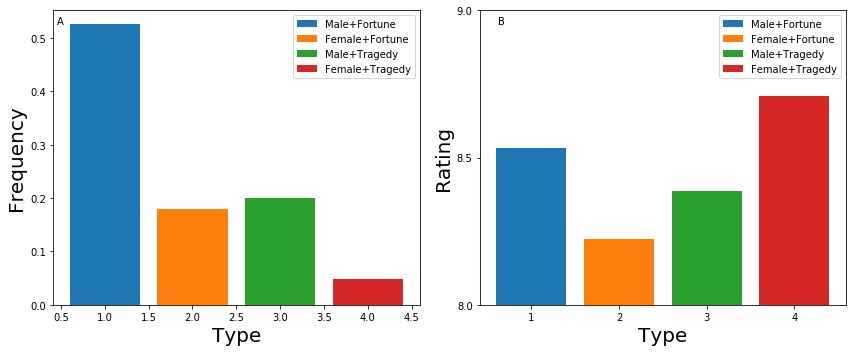

In [42]:
fig = plt.figure(figsize=(12,5))
ax=fig.add_subplot(121)
plt.bar(1,418/795,label='Male+Fortune')
plt.bar(2,143/795,label='Female+Fortune')
plt.bar(3,159/795,label='Male+Tragedy')
plt.bar(4,39/795,label='Female+Tragedy')
plt.legend()
ax.text(0.01, 0.98,'A',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes,size=10)
plt.xlabel('Type',size=20)
plt.ylabel('Frequency',size=20)


ax=fig.add_subplot(122)
plt.bar(1,8.533206,label='Male+Fortune')
plt.bar(2,8.224476,label='Female+Fortune')
plt.bar(3,8.386101,label='Male+Tragedy')
plt.bar(4,8.707949,label='Female+Tragedy')
plt.xticks(range(1,5))
plt.yticks([8,8.5,9,9.5])
plt.ylim(range(8,10))
ax.text(0.05, 0.98,'B',horizontalalignment='left',verticalalignment='top',transform=ax.transAxes,size=10)
plt.legend()
plt.xlabel('Type',size=20)
plt.ylabel('Rating',size=20)


plt.tight_layout()
plt.savefig('./picture/comparison', dpi=200)
plt.show()

### data collection

extract url from cornell

In [21]:
with open('./cornell movie-dialogs corpus/raw_script_urls.txt','rb') as f:
    data=f.readlines()

In [22]:
url_list=[]
number_list=[]
for d in data:
    try:
        d=str(d, encoding='utf-8')
        url_list.append(d.split('+++$+++ ')[2].split('\n')[0])
        number_list.append(d.split(' +++$+++')[0])
    except:
        print(d)
diction=dict(zip(url_list,number_list))

b'm114 +++$+++ l\xe9on +++$+++ http://www.scifiscripts.com/msol/LEON.txt\n'


extract script from cornell

In [47]:
for k,url in enumerate(url_list[35:]):
    flushPrint(k)
    r=urllib.request.urlopen(url)
    content=r.readlines()
    try:
        filename = 'cornell movie-dialogs corpus/corpora/'+diction[url]+'.txt'
        r = requests.get(url)
        content = BeautifulSoup(r.text, 'lxml')
        content=content.find('body').find('pre')
        content=str(content).replace('<pre>',' ')
        content=str(content).replace('</pre>',' ')
        with open(filename, 'w') as f:
            f.write(content)
    except:
        print(k, url)
        pass

0

URLError: <urlopen error [Errno 61] Connection refused>

In [58]:
url = 'http://www.imsdb.com/all%20scripts/'
r = requests.get(url)
content = BeautifulSoup(r.text, 'lxml')
urls = [i.a['href'] for i in content.find_all('p')]

urls=['%20'.join(url.split(' ')) for url in urls]
urls = ['http://www.imsdb.com'+url for url in urls]

extract genre from imsdb

In [158]:
type_list=["Action","Adventure", "Animation","Comedy","Crime","Drama",
"Family","Fantasy","Film-Noir","Horror","Musical","Mystery",
"Romance","Sci-Fi","Short","Thriller","War","Western"]
genre=[]

for k,url in enumerate(urls[243:]):
    flushPrint(k)
    r = requests.get(url)
    content = BeautifulSoup(r.text, 'lxml')
    content=content.find_all('a')
    gen=[]
    for i in content:
        i=i.get('title')
        try:
            for t in type_list:
                if t in i:
                    gen.append(i.split(' ')[0])   
        except:
            pass
    genre.append(gen)

927

extract script from imsdb

In [ ]:
url = 'http://www.imsdb.com/all%20scripts/'
r = requests.get(url)
content = BeautifulSoup(r.text, 'lxml')
urls = [i.a['href'] for i in content.find_all('p')]

urls = ['http://www.imsdb.com/scripts/'+ url.split('/')[2].replace(' Script', '').replace(' ', '-').replace(':', '') for url in urls]

for k, url in enumerate(urls):
    flushPrint(k)
    r = requests.get(url)
    content = BeautifulSoup(r.text, 'lxml')
    try:
        content = content.find_all('td', {'class', 'scrtext'})[0].text
        filename = 'imsdb/'+url.split('/')[-1].replace('html', 'txt')
        with open(filename, 'w') as f:
            f.write(content)
    except:
        print(k, url)
        pass

extract rating/date from imsdb

In [59]:
inf=[]
for k,url in enumerate(urls[1109]):
    flushPrint(k)
    r = requests.get(url)
    content = BeautifulSoup(r.text, 'lxml')
    try:
        content=content.findAll('table')[12].findAll('td')[2].text
        content=content.split('\n')
        rating1=[]
        rating2=[]
        date1=[]
        date2=[]

        for i in content:
            if 'IMSDb rating'in i:
                rating1.append(i)
            if 'Average user rating' in i:
                rating2.append(i)
            if 'Movie Release Date' in i:
                date1.append(i)
            if 'Script Date' in i:
                date2.append(i)
        inf.append([k+596,rating1,rating2,date1,date2])
    except:
        print(k)
        pass

0

MissingSchema: Invalid URL 'h': No schema supplied. Perhaps you meant http://h?

In [147]:
data=pd.read_csv('1.csv',index_col=0)
data=data.drop(['0'],axis=1)
data.columns=['IMSDb_rating','User_rating','Release_date','Script_date']
data['IMSDb_rating']=data['IMSDb_rating'].apply(lambda x: x.split('(')[1][0] if 'out of' in x
                          else np.nan)
data['User_rating']=data['User_rating'].apply(lambda x: x.split('(')[1][:4] if 'out of' in x
                          else np.nan)
data['Release_date']=data['Release_date'].apply(lambda x: x.split(' ')[5][:4] if 'Movie Release Date' in x
                          else np.nan)
data['Script_date']=data['Script_date'].apply(lambda x: x.split(' ')[4][:4] if 'Script Date' in x
                          else np.nan)

In [157]:
movie_type=pd.read_csv('./movie_type.csv',index_col=0)
movie_type['type']=movie_type['0'].astype('str')+','+movie_type['1'].astype('str')+','+\
movie_type['2'].astype('str')+','+movie_type['3'].astype('str')+','+\
movie_type['4'].astype('str')+','+movie_type['5'].astype('str')+','+movie_type['6'].astype('str')
movie_type['IMSDb_rating']=list(data['IMSDb_rating'])
movie_type['User_rating']=list(data['User_rating'])
movie_type['Release_date']=list(data['Release_date'])
movie_type['Script_date']=list(data['Script_date'])
movie_type=movie_type.drop(['0','1','2','3','4','5','6'],axis=1)
movie_type.to_csv('./movie_type.csv')

In [37]:
male=[]
female=[]
files=glob('./imsdb/*')
for file in files:
    with open(file) as f:
        film_script_list = f.readlines()
    film_script_str = ''.join(film_script_list)
    film_script_wordlist = tknzr.tokenize(film_script_str.lower())
    film_name_list = (set(film_script_wordlist) & set(male_names_list)) |\
                        (set(film_script_wordlist) & set(female_names_list))
    film_script_wordlist_counter = Counter(film_script_wordlist)
    film_name_count_df = pd.DataFrame([[i, film_script_wordlist_counter[i]]for i in film_name_list]\
                                      , columns=['name', 'count'])
    lead = film_name_count_df.sort_values(by='count', ascending=False)['name'].values[0]
    if lead in male_names_list:
        male.append(file.split('/')[2].split('.')[0])
    if lead in female_names_list:
        female.append(file.split('/')[2].split('.')[0])

In [38]:
movie_type=pd.read_csv('./movie_type.csv',index_col=0)

In [39]:
len(male)

870

In [40]:
len(female)

475

In [41]:
len(files)

1138

In [70]:
male_df=movie_type.loc[movie_type['name'].isin(male)].index
movie_type.ix[male_df,'gender']=0

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
female_df=movie_type.loc[movie_type['name'].isin(female)].index
movie_type.ix[female_df,'gender']=1

In [74]:
movie_type.to_csv('./movie_type.csv',index=False)

In [176]:
movie_type['ending_10'].value_counts()

0.0    667
1.0    448
Name: ending_10, dtype: int64

In [186]:
movie_type[movie_type['ending_10']==0]['User_rating'].mean()

8.45824945295405

In [182]:
movie_type[movie_type['ending_10']==0]['gender'].value_counts()

0.0    495
1.0    172
Name: gender, dtype: int64

In [189]:
film_type=list(movie_type[movie_type['ending_10']==1]['type'])
film_type=','.join(film_type)
film_type=film_type.split(',')
film_counter=Counter(film_type)

In [190]:
sorted(film_counter.items(),key = lambda x:x[1],reverse = True)

[('nan', 2319),
 ('Drama', 182),
 ('Comedy', 107),
 ('Thriller', 105),
 ('Action', 82),
 ('Crime', 54),
 ('Sci-Fi', 45),
 ('Romance', 43),
 ('Horror', 40),
 ('Adventure', 37),
 ('Mystery', 34),
 ('Fantasy', 33),
 ('Animation', 13),
 ('Musical', 9),
 ('Family', 8),
 ('War', 6),
 ('Star', 4),
 ('Scripts', 3),
 ('Western', 2),
 ('Short', 2),
 ('Film-Noir', 2),
 ('Adventures', 1),
 ('Chronicles', 1),
 ('Mad', 1),
 ('True', 1),
 ('Warm', 1),
 ('Warrior', 1)]

### validation

#### case

In [27]:
def wordavg(script,words):
    try:
        wordlist=list(words['word'])
        common=[w for w in wordlist if w in script]
        df=words.loc[words['word'].isin(common)]

        diction=Counter(scriptlist)

        df['freq']=df['word'].apply(lambda x:diction[x] if x in diction
                                   else np.nan)
#         df=df[(df['happiness_average']>7) |(df['happiness_average']<3)]

        avg=sum(df['happiness_average']*df['freq'])/sum(df['freq'])
    except:
        avg=4.5
    return avg

In [9]:
words=pd.read_csv('./words.csv')

In [16]:
with open('/Users/xuhuimin/storytelling/imsdb/Shawshank-Redemption,-The.txt') as f:
# with open('/Users/xuhuimin/storytelling/imsdb/Titanic.txt') as f:
    film_script_list = f.readlines()
film_script_str = ''.join(film_script_list)

tknzr = WordPunctTokenizer()
corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
corpus = [i for i in corpus if i != []]

In [17]:
n_split = 100
corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


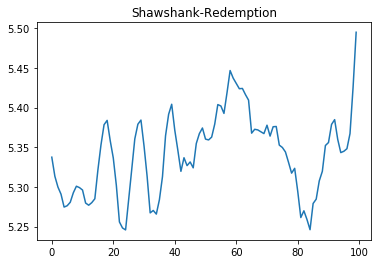

In [20]:
avglist=[]
for n in range(n_split):
    scriptlist=[]
    for i in range(len(corpus[n])):
        scriptlist.extend(corpus[n][i])
    avglist.append(wordavg(scriptlist,words))
    
exa = np.array(avglist)
exa = savitzky_golay(exa, 11, 3) # window size 51, polynomial order 3
p30 = np.poly1d(np.polyfit(range(len(avglist)),exa, 3))
plt.title('Shawshank-Redemption')
plt.plot(range(len(avglist)),exa,label='smooth')

# plt.plot(avglist)

#### visulization

In [39]:
files=glob('./imsdb/*')
alllist=[]
for file in files:
    with open(file) as f:
        film_script_list = f.readlines()
    try:
        film_script_str = ''.join(film_script_list)

        tknzr = WordPunctTokenizer()
        corpus = [tknzr.tokenize(i.lower()) for i in film_script_str.split('\n')]
        corpus = [i for i in corpus if i != []]
        n_split = 10
        corpus = [corpus[int(len(corpus)/n_split*i):int(len(corpus)/n_split*(i+1)-1)] for i in range(n_split)]
        avglist=[]
        for n in range(n_split):
            scriptlist=[]
            for i in range(len(corpus[n])):
                scriptlist.extend(corpus[n][i])
            avglist.append(wordavg(scriptlist,words))
        alllist.append([file,avglist])
    except Exception as e:
        print(e)
        print(file, 'wrong')
        pass

In [59]:
name=[i[0].split('/')[-1].split('.')[0] for i in alllist]

vec=[i[1] for i in alllist]

diction=dict(zip(name,vec))

movie_type=pd.read_csv('./movie_type.csv',index_col=0)
movie_type['vec']=movie_type['name'].apply(lambda x: diction[x] if x in diction
                                          else np.nan)

In [61]:
movie_type.to_csv('movie_type.csv',index=False)

In [251]:
movie_type=pd.read_csv('./movie_type.csv')

In [293]:
pears=[]
for i in range(len(movie_type)):
    try:
        a=eval(movie_type['vec'][i])
#         a=normalize(a)
        a=normalize(savitzky_golay(np.array(a),11,3))
        b=eval(movie_type['wordvec'][i])
#         b=normalize(b)
        b=normalize(savitzky_golay(np.array(b),11,3))
        pears.append(np.corrcoef(a, b)[0, 1])
    except:
        pass

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [290]:
len(pears)

1114

In [281]:
pears=[x for x in pears if str(x) != 'nan']

In [282]:
np.mean(pears)

0.16644517583313448

In [287]:
correct=[x for x in pears if x >0]

In [288]:
len(correct)

640

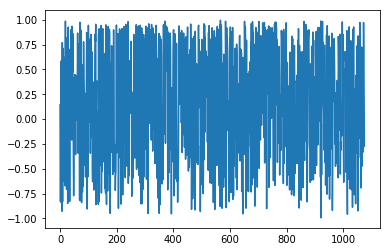

In [285]:
plt.plot(pears)

In [315]:
a=eval(movie_type['vec'][2])

In [316]:
a

[6.3326605504587175,
 5.64264957264957,
 5.864414414414413,
 6.00070796460177,
 6.313518518518516,
 5.9696453900709185,
 6.165098039215684,
 6.332871287128712,
 5.654509803921569,
 5.357209302325581]

In [317]:
a.index(max(a))+1

8

In [312]:
b=eval(movie_type['wordvec'][1])

In [313]:
b

[12.95863330645571,
 12.95863330645571,
 12.95863330645571,
 18.857275529223188,
 9.783994094305996,
 12.95863330645571,
 12.95863330645571,
 12.95863330645571,
 18.857275529223188,
 18.857275529223188]

In [314]:
b.index(max(b))+1

4

### SVD

#### case

In [23]:
# I like deep learning. 

# I like NLP.

# I enjoy flying.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
 
la = np.linalg
words = ["I","like","enjoy","deep","learning","NLP","flying","."]
 
X=np.array([[0,2,1,0,0,0,0,0],[2,0,0,1,0,1,0,0],[1,0,0,0,0,0,1,0],[0,1,0,0,1,0,0,0],[0,0,0,1,0,0,0,1],[0,1,0,0,0,0,0,1],[0,0,1,0,0,0,0,1],[0,0,0,0,1,1,1,0]])
 
W,sigma,CT=la.svd(X,full_matrices=False)


In [27]:
X.shape

(8, 8)

In [28]:
W.shape

(8, 8)

In [18]:
sigma

array([2.75726275, 2.678248  , 1.89221277, 1.61803399, 1.19154564,
       0.94833983, 0.61803399, 0.56999221])

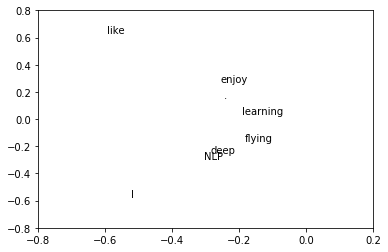

In [20]:
plt.axis([-0.8,0.2,-0.8,0.8])
 
for i in range(len(words)):
    plt.text(W[i,0],W[i,1],words[i])
plt.show()

#### application

In [227]:
movie_type=pd.read_csv('./movie_type.csv')

In [228]:
# for i in range(len(movie_type)):
#     try:
#         movie_type['wordvec100'][i]=eval(movie_type['wordvec100'].values[i])
#     except:
#         pass

In [229]:
movie_type=movie_type[movie_type['wordvec100'].astype(str)!='nan']

In [230]:
movie_type['wordvec100']=movie_type['wordvec100'].apply(lambda x: eval(x))

In [231]:
movie_type['wordvec100']=movie_type['wordvec100'].apply(lambda x: savitzky_golay(np.array(x), 33, 3))

In [232]:
len(movie_type)

1109

In [233]:
movie_type=movie_type[['name','wordvec100','gender']]

In [234]:
q=movie_type.values

In [235]:
big_matrix=np.ones([len(q),100])

In [236]:
for i,b in enumerate(q):
    big_matrix[i,:]=b[-2]

In [237]:
big_matrix.shape

(1109, 100)

In [238]:
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(100,1)).transpose() #relative happiness

In [212]:
# big_matrix_mean0 = (big_matrix-big_matrix.mean(axis=0))/ big_matrix.std(axis=0)

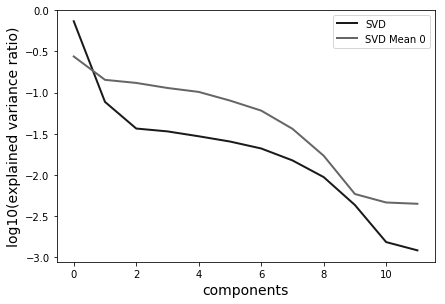

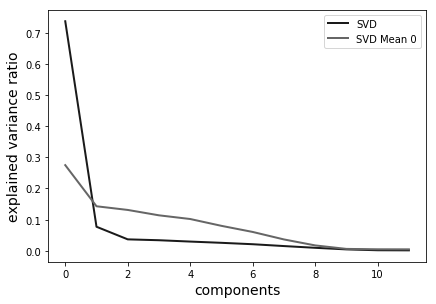

In [239]:
# pca = PCA(n_components='mle')
svd = TruncatedSVD(n_components=12,algorithm='arpack')
svd.fit(big_matrix)
# svd.n_components_

fig = plt.figure(figsize=(7.5,5))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
ax1.plot(np.log10(svd.explained_variance_ratio_),linewidth=2,color=".1")


# pca = PCA(n_components='mle')
svd2 = TruncatedSVD(n_components=12,algorithm='arpack')
svd2.fit(big_matrix_mean0)
# svd.n_components_

ax1.plot(np.log10(svd2.explained_variance_ratio_),linewidth=2,color=".4")
ax1.legend(['SVD','SVD Mean 0'])
ax1.set_ylabel('log10(explained variance ratio)',fontsize=14)
ax1.set_xlabel('components',fontsize=14)
# mysavefig("SVD-variance.pdf",folder="media/figures/SVD",openfig=False)

fig = plt.figure(figsize=(7.5,5))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
ax1.plot(svd.explained_variance_ratio_,linewidth=2,color=".1")
ax1.plot(svd2.explained_variance_ratio_,linewidth=2,color=".4")
ax1.legend(['SVD','SVD Mean 0'])
ax1.set_ylabel('explained variance ratio',fontsize=14)
ax1.set_xlabel('components',fontsize=14)
# mysavefig('svd-{0}components-30-50-explainedvariance-both.svg'.format(12))
# mysavefig('svd-{0}components-30-50-explainedvariance-both.png'.format(12))
# mysavefig("SVD-log10variance.pdf",folder="media/figures/SVD",openfig=False)

In [240]:
print(np.cumsum(svd.explained_variance_ratio_))
print(np.cumsum(svd2.explained_variance_ratio_))

[0.73753122 0.81457423 0.85110264 0.88482056 0.91423183 0.9396209
 0.96050872 0.97547207 0.98484616 0.98913407 0.99065168 0.99185594]
[0.27507131 0.41794425 0.54903135 0.66280727 0.76472086 0.84467079
 0.90501458 0.94128945 0.9583493  0.9641843  0.96878569 0.97322359]


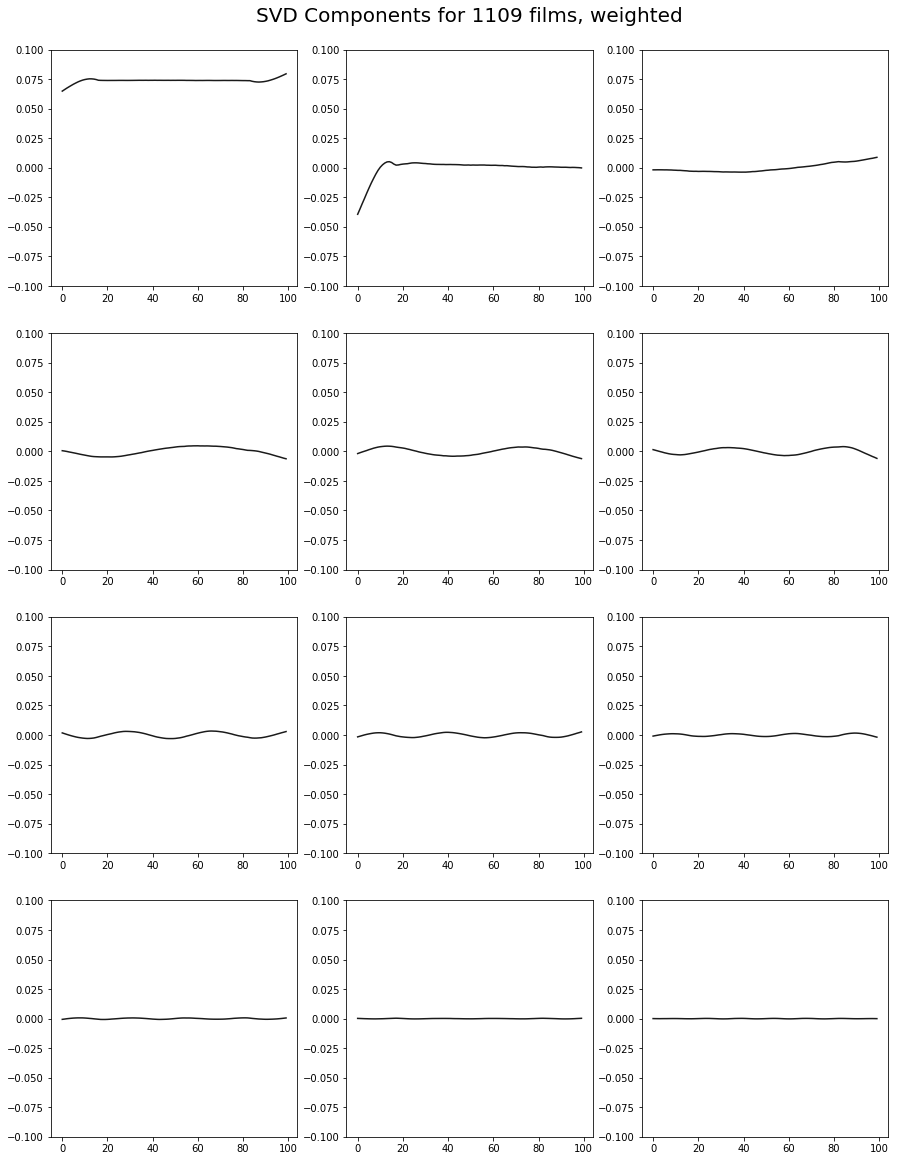

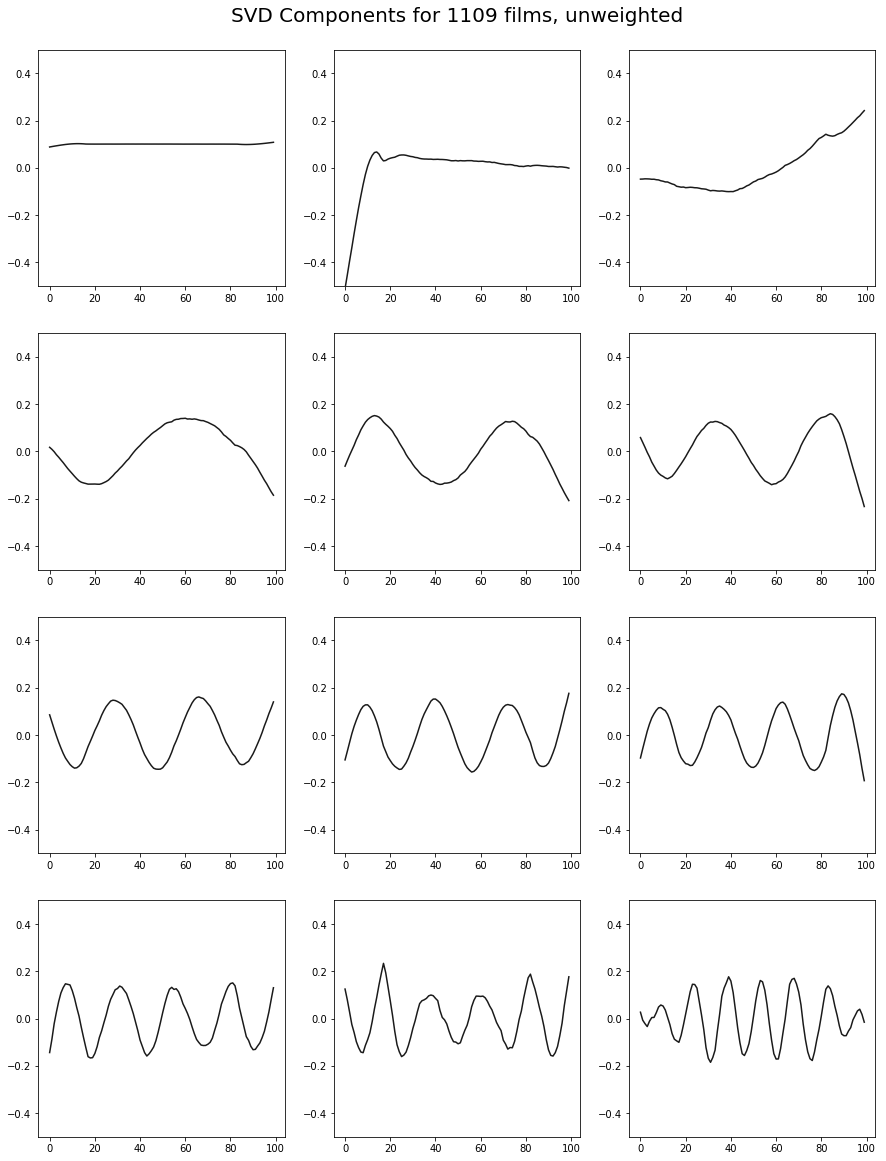

In [241]:
fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(svd.components_[i]*svd.explained_variance_ratio_[i],color=".1",linewidth=1.5)
    plt.ylim([-0.1,0.1])
plt.subplot(4,3,2)
plt.title("SVD Components for {} films, weighted\n".format(len(q)),fontsize=20)
# mysavefig('pca-MLEcomponents-first12.png')
# mysavefig("SVD-timeseries-weighted.pdf",folder="media/figures/SVD",openfig=False)

fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(svd.components_[i],color=".1",linewidth=1.5)
    plt.ylim([-0.5,0.5])
plt.subplot(4,3,2)
plt.title("SVD Components for {} films, unweighted\n".format(len(q)),fontsize=20)

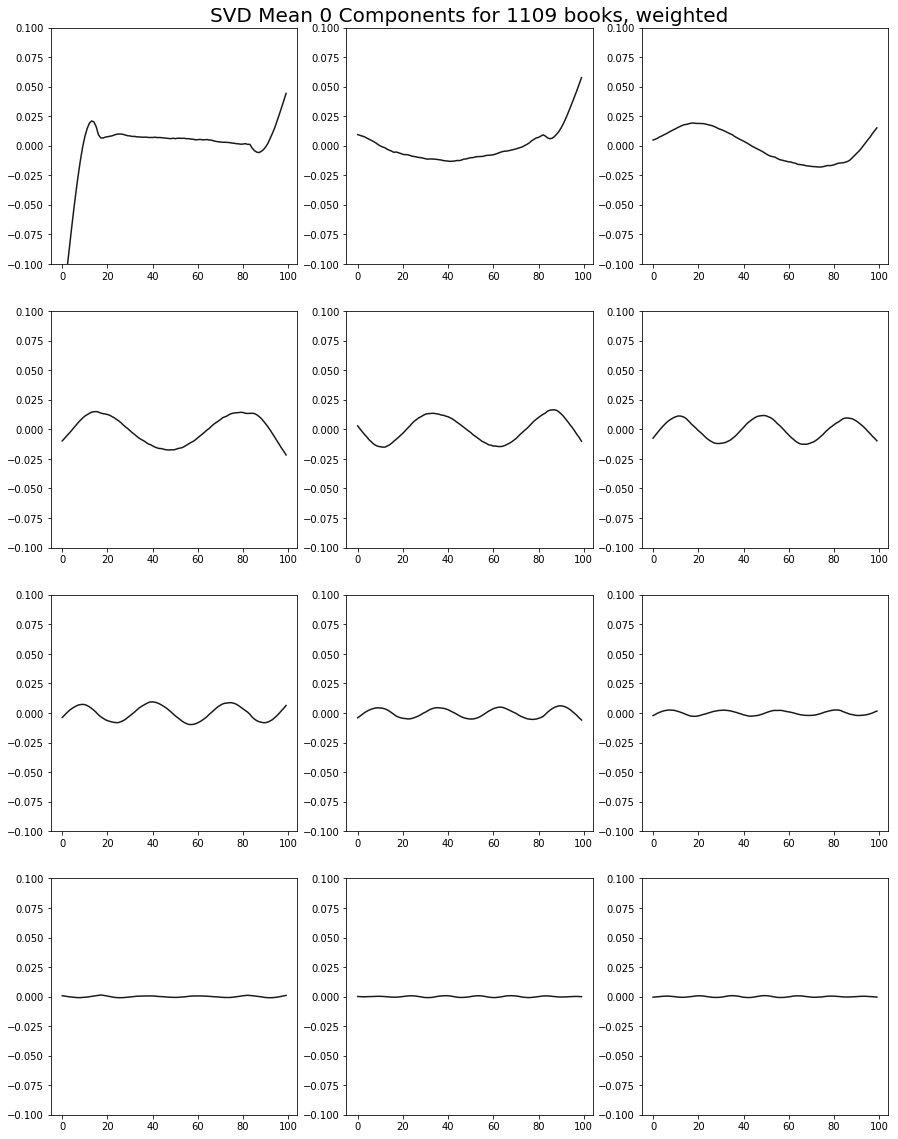

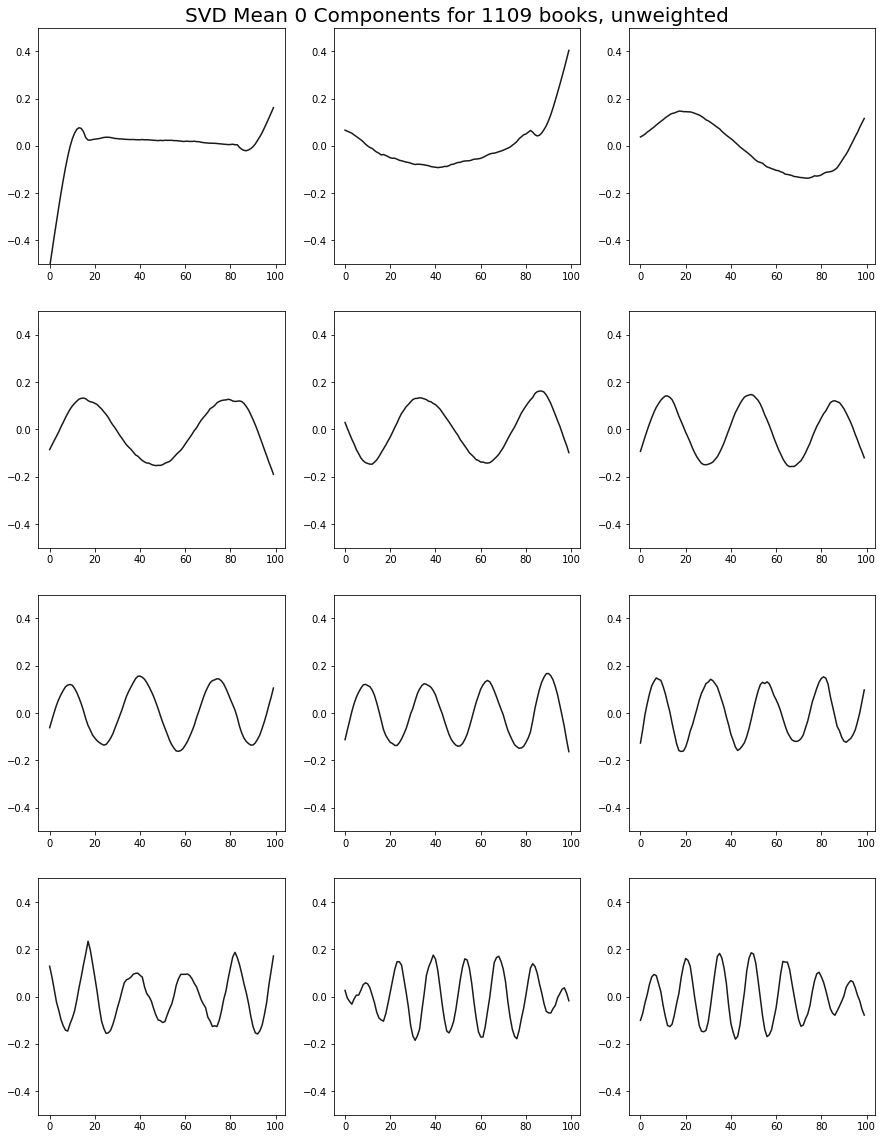

In [242]:
fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(svd2.components_[i]*svd2.explained_variance_ratio_[i],color=".1",linewidth=1.5)
    plt.ylim([-.1,.1])
plt.subplot(4,3,2)
plt.title("SVD Mean 0 Components for {} books, weighted".format(len(q)),fontsize=20)
# mysavefig('pca-MLEcomponents-first12.png')
# mysavefig("SVD-timeseries-weighted-mean0.pdf",folder="media/figures/SVD",openfig=False)

fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(svd2.components_[i],color=".1",linewidth=1.5)
    plt.ylim([-.5,.5])
plt.subplot(4,3,2)
plt.title("SVD Mean 0 Components for {} books, unweighted".format(len(q)),fontsize=20)
# mysavefig('pca-MLEcomponents-first12.png')
# mysavefig("SVD-timeseries-unweighted-mean0.pdf",folder="media/figures/SVD",openfig=False)

In [243]:
U,S,V = np.linalg.svd(big_matrix_mean0,full_matrices=True,compute_uv=True)

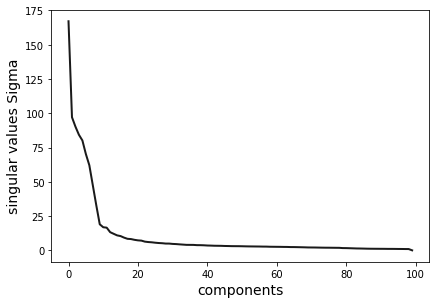

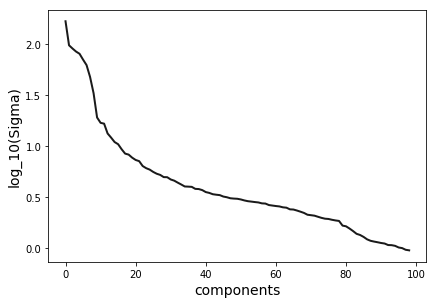

In [244]:
fig = plt.figure(figsize=(7.5,5))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
ax1.plot(S,linewidth=2,color=".1")
ax1.set_ylabel('singular values Sigma',fontsize=14)
ax1.set_xlabel('components',fontsize=14)
# mysavefig('pca-{0}components-explainedvariance-mean0.png'.format(pca.n_components_))
# mysavefig("SVD-variance-numpy.pdf",folder="media/figures/SVD",openfig=False)

fig = plt.figure(figsize=(7.5,5))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
ax1.plot(np.log10(S[:-1]),color=".1",linewidth=2)
ax1.set_ylabel('log_10(Sigma)',fontsize=14)
ax1.set_xlabel('components',fontsize=14)
# mysavefig('pca-{0}components-explainedvariance-mean0.png'.format(pca.n_components_))
# mysavefig("SVD-log10variance-numpy.pdf",folder="media/figures/SVD",openfig=False)

In [245]:
print(U.shape)
print(S.shape)
print(V.shape)

(1109, 1109)
(100,)
(100, 100)


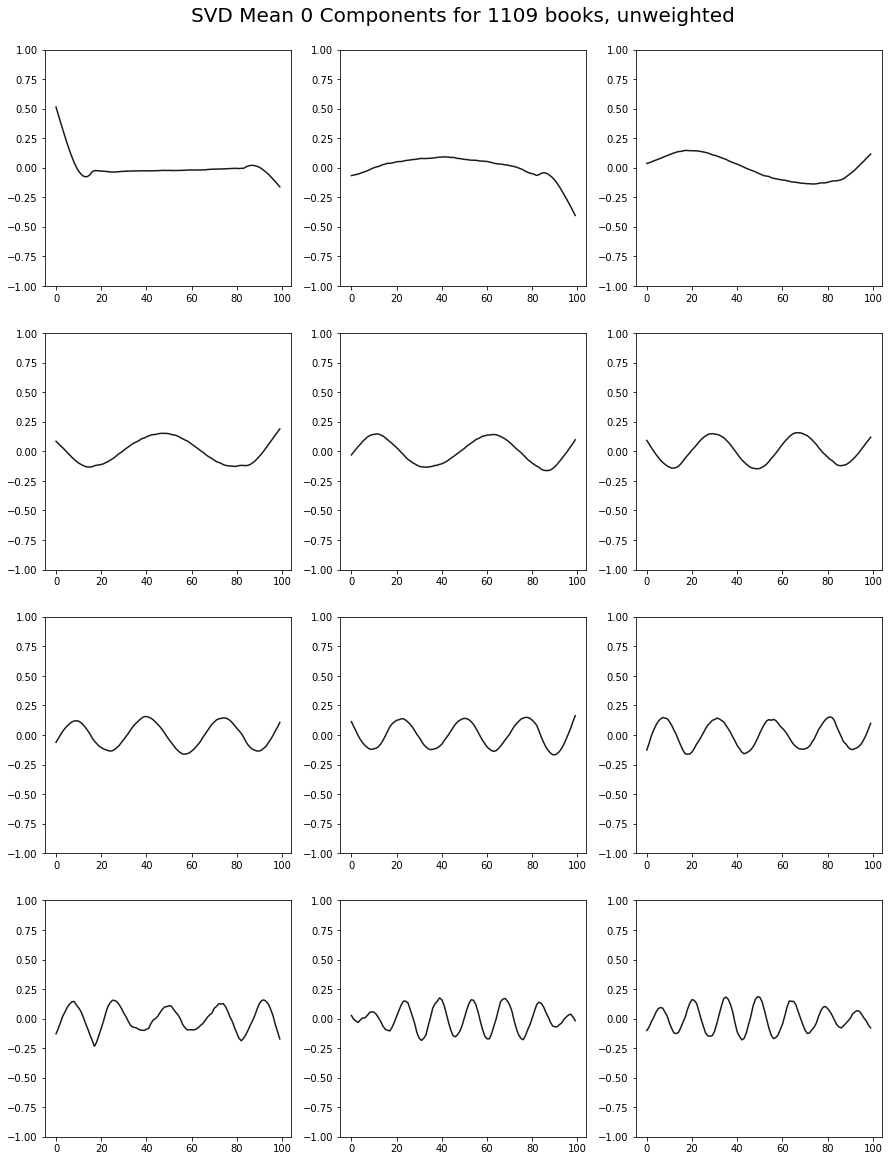

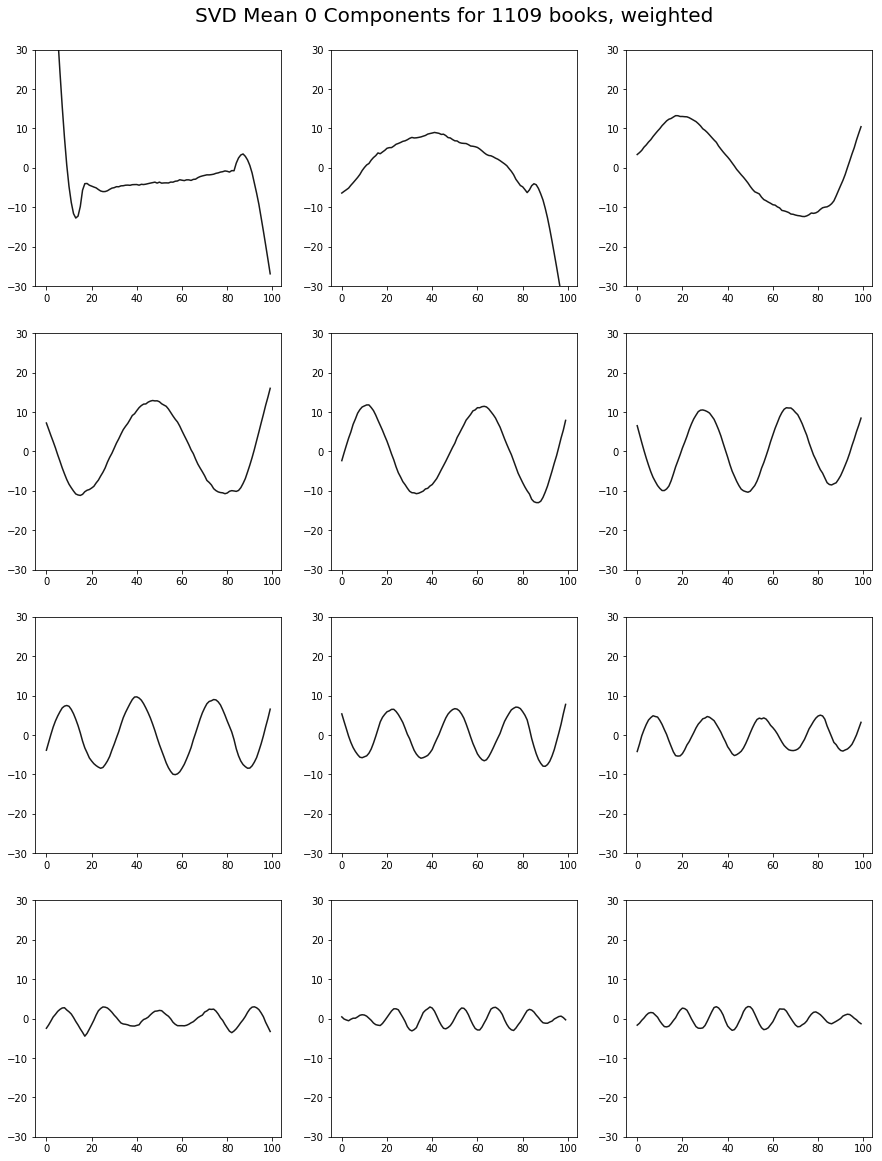

In [246]:
fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(V[i,:],color=".1",linewidth=1.5)
    plt.ylim([-1,1])
plt.subplot(4,3,2)
plt.title("SVD Mean 0 Components for {} books, unweighted\n".format(len(q)),fontsize=20)
# mysavefig('pca-MLEcomponents-first12.png')
# mysavefig("SVD-timeseries-unweighted-mean0-numpy.pdf",folder="media/figures/SVD",openfig=False)

fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(V[i,:]*S[i],color=".1",linewidth=1.5)
    plt.ylim([-30,30])
plt.subplot(4,3,2)
plt.title("SVD Mean 0 Components for {} books, weighted\n".format(len(q)),fontsize=20)
# mysavefig("SVD-timeseries-weighted-mean0-numpy.pdf",folder="media/figures/SVD",openfig=False)

In [247]:
w = U[:,:100]*S
print(w.shape)

(1109, 100)


In [248]:
w_abs = np.abs(w)
w_normalized = np.multiply(w,np.tile(1./w_abs.sum(axis=1),(100,1)).transpose())

In [249]:
num_modes = 10
all_lists = [{} for i in range(num_modes)]
for m in range(num_modes):
    all_lists[m]["top_abs"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: x[1])
    all_lists[m]["top_abs_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: x[1])

In [283]:
def plot_svs(svstart,v=True,fix_ylim=0.0,xspacing=.01):
    nsvs = 3
    xoffset = .1
    xwidth = (1.-xoffset)/(nsvs)-xspacing
    print('xwidth is {0}'.format(xwidth))
    
    chars = 60
    
    fig = plt.figure(figsize=(15,12))
    for sv in range(0,3):
        print(sv)
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+sv*(xspacing+xwidth),.6,xwidth,.35]
        ax1 = fig.add_axes(ax1rect)
        ax1books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.5,xwidth,.1])
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart]["top_pos_norm"][:15]:
            ax1.plot(-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b[0])
            if j<3:
                if len(b[0]) > chars:
                    ax1books.text(0.0,0.5-j*.2,'{0}: {1}...'.format(j+1,b[0][:chars-3].replace("\n",": ")),fontsize=10)
                else:
                    ax1books.text(0.0,0.5-j*.2,'{0}: {1}'.format(j+1,b[0].replace("\n",": ")),fontsize=10)
            j+=1
        ax1.plot(-V[sv+svstart,:],color="#ff6700",linewidth=2,label="SV {}".format(sv+svstart+1))
#         ax1.set_xticks([10,20,30,40,50,60,70,80,90])
#         ax1.set_xticklabels(["10","20","30","40","50","60","70","80","90"])
#         ax1.text(.98,0.02,r"% of Book",ha="right",va="bottom",transform=ax1.transAxes)
        ax1.legend(loc="upper left")
    
        
        
        #ax1.axis('off')
        ax1books.axis('off')

        ax2 = fig.add_axes([xoffset+sv*(xspacing+xwidth),.1,xwidth,.35])
        ax2books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.0,xwidth,.1])
        # ax2.set_title('20 closest negative correlates')
        if v:
            print('-'*80)
            print('20 closest negative correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart]["top_neg_norm"][:15]:
            ax2.plot(big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b[0])
            if j<3:
                if len(b[0]) > chars:
                    ax2books.text(0.0,.5-j*.2,'{0}: {1}...'.format(j+1,b[0][:chars-3].replace("\n",": ")),fontsize=10)
                else:
                    ax2books.text(0.0,.5-j*.2,'{0}: {1}'.format(j+1,b[0].replace("\n",": ")),fontsize=10)
            j+=1
        ax2.plot(V[sv+svstart,:],color="#ff6700",linewidth=2,label="(SV {})".format(sv+svstart+4))
#         ax2.set_xticks([10,20,30,40,50,60,70,80,90])
#         ax2.set_xticklabels(["10","20","30","40","50","60","70","80","90"])
#         ax2.text(.98,0.02,r"% of Book",ha="right",va="bottom",transform=ax1.transAxes)
        ax2.legend(loc="upper left")

        #ax1.axis('off')
        ax2books.axis('off')
        if fix_ylim > 0:
            ax1.set_ylim([-fix_ylim,fix_ylim])
            ax2.set_ylim([-fix_ylim,fix_ylim])
        if sv > 0:
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])

    
    plt.savefig('./picture/mode.png',dpi=200)

        
        


xwidth is 0.29
0
1
2


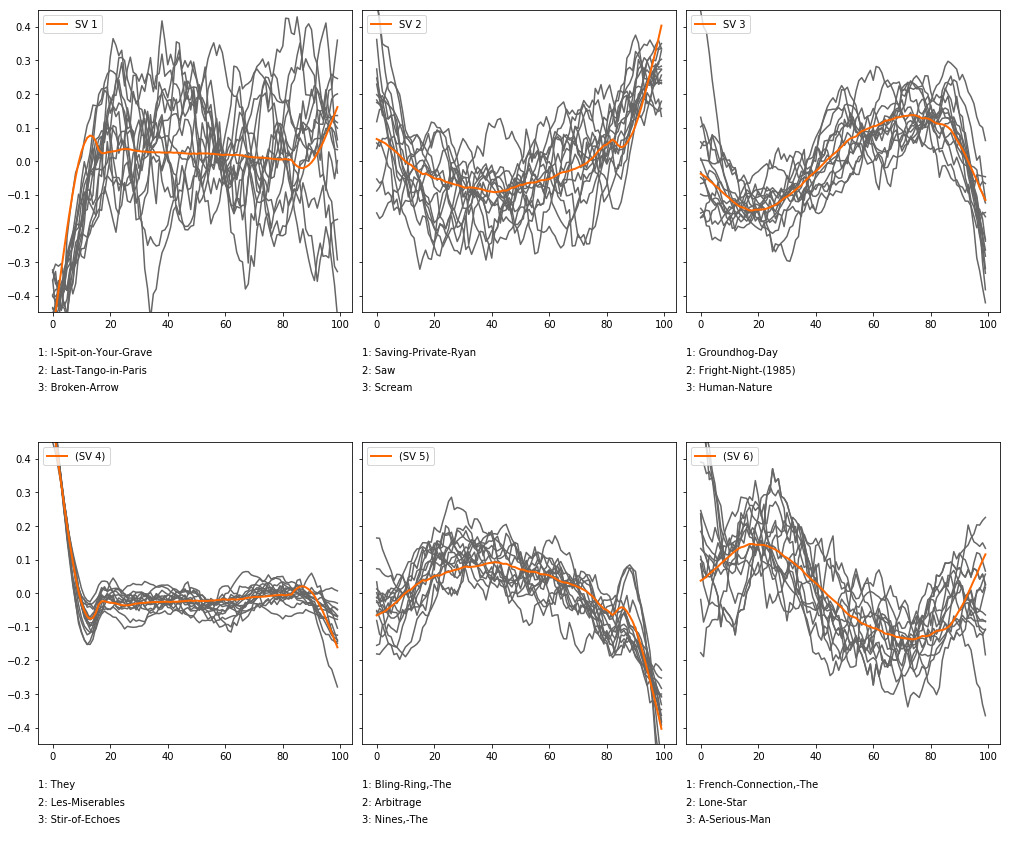

In [284]:
plot_svs(0,v=False,fix_ylim=0.45)

xwidth is 0.29
0
1
2


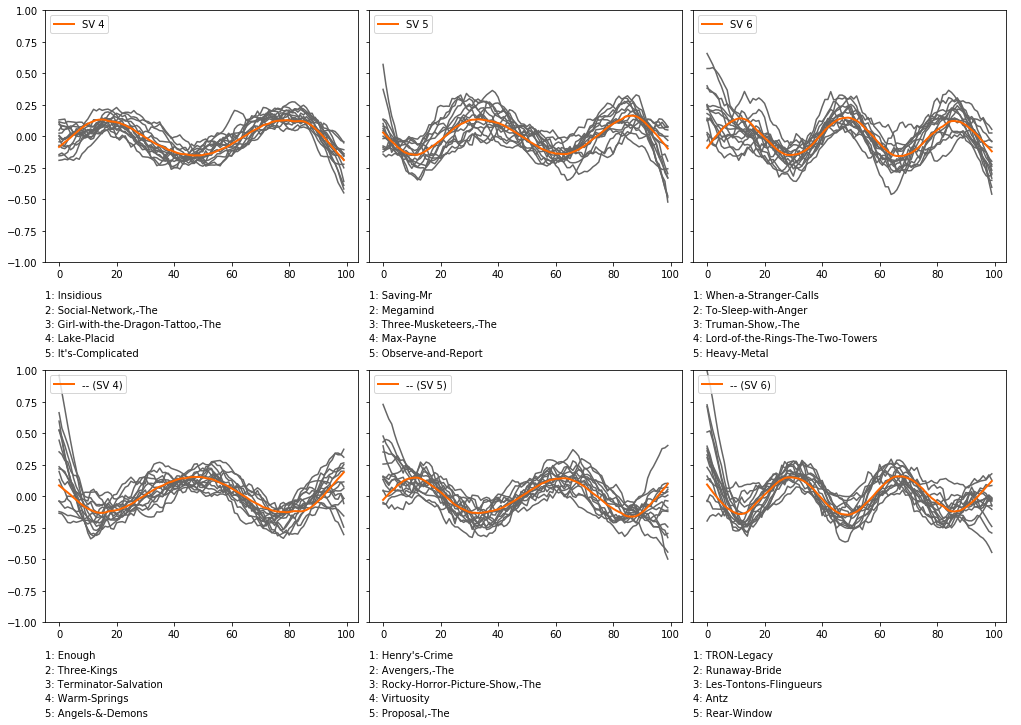

In [252]:
plot_svs(3,v=False,fix_ylim=1)

In [285]:
core_emotional_arcs = [sorted(zip(w_normalized[i,:],
                                  range(1,len(w_normalized[i,:])+1)),
                              key=lambda x: np.abs(x[0]),
                              reverse=True) for i,b in enumerate(q)]

all_downloads = [b[2] for b in q]

In [286]:
# split onto the positive and negative of each mode
pos_stories = [[] for i in range(len(core_emotional_arcs[0]))]
neg_stories = [[] for i in range(len(core_emotional_arcs[0]))]

for i in range(len(core_emotional_arcs)):
    if core_emotional_arcs[i][0][0] > 0:
        pos_stories[core_emotional_arcs[i][0][1]-1].append(i)
    else:
        neg_stories[core_emotional_arcs[i][0][1]-1].append(i)
print(pos_stories[0][:10])
print(neg_stories[0][:10])

[192, 198, 401, 519, 606, 664, 754, 810]
[0, 2, 7, 9, 12, 13, 16, 18, 21, 26]


In [287]:
def core_stats(book_indices):
    N = len(book_indices)
    percentage = N/len(q)*100
    these_downloads = [q[i][2] for i in book_indices]
    percentage_more = np.sum(these_downloads>np.mean(all_downloads))/len(these_downloads)*100
    return N,percentage,np.mean(these_downloads),np.median(these_downloads),these_downloads,np.var(these_downloads),percentage_more
def find_bin_i(bins,x):
    j = 0
    while bins[j] < x:
        j+=1
    return j-1

In [289]:
for i in range(15):
    stats = core_stats(pos_stories[i])
    print("SV {}".format(i+1),stats[:4])
#     print(pos_stories[i])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    # ax.set_xlim([100,1000])
    # ax.hist(stats[4],bins=np.arange(100,20000,100),color=".5")
    # ax.hist(stats[4],color=".5")
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    # ax.set_xlim([100,20000])
    ax.axis("off")
#     mysavefig("SV{0}-+-sparkhist.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100),V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
#     mysavefig("SV{0}-+-spark.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    stats = core_stats(neg_stories[i])
    print("-SV {}".format(i+1),stats[:4])
#     print(neg_stories[i])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    ax.axis("off")
#     mysavefig("SV{0}---sparkhist.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100),-V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
#     mysavefig("SV{0}---spark.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)

SV 1 (8, 0.7213706041478809, 0.25, 0.0)
-SV 1 (390, 35.166816952209196, 0.2230769230769231, 0.0)


/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


SV 2 (44, 3.967538322813345, 0.20454545454545456, 0.0)
-SV 2 (146, 13.165013525698827, 0.2671232876712329, 0.0)
SV 3 (86, 7.75473399458972, 0.2441860465116279, 0.0)
-SV 3 (56, 5.049594229035167, 0.2857142857142857, 0.0)
SV 4 (91, 8.205590622182147, 0.25274725274725274, 0.0)
-SV 4 (48, 4.328223624887286, 0.25, 0.0)
SV 5 (67, 6.0414788097385035, 0.2537313432835821, 0.0)
-SV 5 (32, 2.8854824165915236, 0.28125, 0.0)
SV 6 (37, 3.3363390441839496, 0.13513513513513514, 0.0)
-SV 6 (36, 3.2461677186654643, 0.2222222222222222, 0.0)
SV 7 (41, 3.69702434625789, 0.2682926829268293, 0.0)
-SV 7 (10, 0.9017132551848512, 0.2, 0.0)
SV 8 (11, 0.9918845807033363, 0.2727272727272727, 0.0)
-SV 8 (5, 0.4508566275924256, 0.0, 0.0)
SV 9 

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages

(1, 0.09017132551848511, 1.0, 1.0)
-SV 9 (0, 0.0, nan, nan)
SV 10 (0, 0.0, nan, nan)
-SV 10 (0, 0.0, nan, nan)
SV 11 (0, 0.0, nan, nan)
-SV 11 (0, 0.0, nan, nan)
SV 12 (0, 0.0, nan, nan)
-SV 12 (0, 0.0, nan, nan)
SV 13 (0, 0.0, nan, nan)
-SV 13 (0, 0.0, nan, nan)
SV 14 (0, 0.0, nan, nan)
-SV 14 (0, 0.0, nan, nan)
SV 15 (0, 0.0, nan, nan)
-SV 15 (0, 0.0, nan, nan)


In [198]:
for i in range(15):
    stats = core_stats(pos_stories[i])
    print("SV {}".format(i+1),stats[:4])
#     print(pos_stories[i])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    # ax.set_xlim([100,1000])
    # ax.hist(stats[4],bins=np.arange(100,20000,100),color=".5")
    # ax.hist(stats[4],color=".5")
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    # ax.set_xlim([100,20000])
    ax.axis("off")
#     mysavefig("SV{0}-+-sparkhist.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
#     mysavefig("SV{0}-+-spark.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    stats = core_stats(neg_stories[i])
    print("-SV {}".format(i+1),stats[:4])
#     print(neg_stories[i])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    ax.axis("off")
#     mysavefig("SV{0}---sparkhist.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),-V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
#     mysavefig("SV{0}---spark.pdf".format(i+1),folder=this_dir,date=False,openfig=False,pdfcrop=True)
    plt.close(fig)

SV 1 (360, 32.46167718665464, 0.2638888888888889, 0.0)
-SV 1 (266, 23.98557258791704, 0.21052631578947367, 0.0)


/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


SV 2 (33, 2.9756537421100093, 0.24242424242424243, 0.0)
-SV 2 (30, 2.7051397655545535, 0.2, 0.0)
SV 3 (21, 1.8935978358881875, 0.2857142857142857, 0.0)
-SV 3 (25, 2.254283137962128, 0.16, 0.0)
SV 4 (26, 2.3444544634806133, 0.23076923076923078, 0.0)
-SV 4 (30, 2.7051397655545535, 0.23333333333333334, 0.0)
SV 5 (29, 2.6149684400360687, 0.13793103448275862, 0.0)
-SV 5 (28, 2.5247971145175834, 0.14285714285714285, 0.0)
SV 6 (27, 2.4346257889990985, 0.2962962962962963, 0.0)
-SV 6 (24, 2.164111812443643, 0.3333333333333333, 0.0)
SV 7 (17, 1.532912533814247, 0.29411764705882354, 0.0)
-SV 7 (23, 2.0739404869251574, 0.13043478260869565, 0.0)
SV 8 (20, 1.8034265103697025, 0.1, 0.0)
-SV 8 (16, 1.4427412082957618, 0.1875, 0.0)
SV 9 (23, 2.0739404869251574, 0.30434782608695654, 0.0)
-SV 9 (17, 1.532912533814247, 0.17647058823529413, 0.0)
SV 10 (15, 1.3525698827772767, 0.4, 0.0)
-SV 10 (17, 1.532912533814247, 0.17647058823529413, 0.0)
SV 11 (8, 0.7213706041478809, 0.125, 0.0)
-SV 11 (11, 0.991884580

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


(9, 0.8115419296663661, 0.4444444444444444, 0.0)
-SV 13 (4, 0.36068530207394045, 0.0, 0.0)
SV 14 (5, 0.4508566275924256, 0.0, 0.0)
-SV 14 (4, 0.36068530207394045, 0.75, 1.0)
SV 15 (2, 0.18034265103697023, 0.5, 0.5)
-SV 15 (3, 0.2705139765554554, 0.6666666666666666, 1.0)


In [427]:
for m in range(15):
    name=[]
    for i in pos_stories[m]:
        name.append(q[i][0])

    mode_df=movie_type.loc[movie_type['name'].isin(name)].index
    movie_type.ix[mode_df,'mode']=m+1
    
    name=[]
    for i in neg_stories[m]:
        name.append(q[i][0])

    mode_df=movie_type.loc[movie_type['name'].isin(name)].index
    movie_type.ix[mode_df,'mode']=-(m+1)  
    

In [430]:
diction=dict(movie_type[['name','mode']].values)

In [431]:
movie_type=pd.read_csv('./movie_type.csv')

In [433]:
movie_type['mode']=movie_type['name'].apply(lambda x: diction[x] if x in diction
                                   else np.nan)

In [436]:
movie_type.to_csv('./movie_type.csv',index=False)

In [20]:
movie_type=pd.read_csv('./movie_type.csv')

In [21]:
movie_type.describe()

,ending,IMSDb_rating,User_rating,Release_date,Script_date,gender,ending_10,mode
count,1109.000000,88.000000,759.000000,590.000000,640.000000,1109.000000,1109.000000,1109.000000
mean,0.073940,7.079545,8.453202,2001.344068,1996.631250,0.238954,0.402164,-0.779080
std,0.261792,1.627505,1.637484,15.948940,11.980486,0.426637,0.490556,3.748029
min,0.000000,1.000000,1.000000,1929.000000,1935.000000,0.000000,0.000000,-10.000000
25%,0.000000,6.000000,7.750000,1999.000000,1992.000000,0.000000,0.000000,-2.000000
50%,0.000000,7.000000,9.000000,2007.000000,1998.000000,0.000000,0.000000,-1.000000
75%,0.000000,8.000000,9.710000,2010.000000,2006.000000,0.000000,1.000000,-1.000000
max,1.000000,9.000000,10.000000,2016.000000,2015.000000,1.000000,1.000000,10.000000


In [22]:
for i in ['IMSDb_rating', 'User_rating', 'Release_date','Script_date','gender']:
    mean=movie_type[i].mean()
    movie_type[i][movie_type[i].isnull()]=mean

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
X = movie_type[['ending', 'IMSDb_rating', 'User_rating', 'Release_date','Script_date','gender']]
y = movie_type['mode']
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.3,random_state=42)

In [39]:
lr = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
lr.fit(X_train, y_train) # will output array with integer values.
preds = lr.predict(X_test) 

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [40]:
Counter(preds)

Counter({-1.0: 332, 5.0: 1})

In [42]:
accuracy_score(y_test, preds)

0.45045045045045046

In [45]:
Counter(movie_type['mode'])

Counter({-10.0: 1,
         -9.0: 5,
         -8.0: 17,
         -7.0: 49,
         -6.0: 38,
         -5.0: 30,
         -4.0: 71,
         -3.0: 50,
         -2.0: 113,
         -1.0: 502,
         1.0: 3,
         2.0: 30,
         3.0: 40,
         4.0: 25,
         5.0: 38,
         6.0: 26,
         7.0: 20,
         8.0: 24,
         9.0: 21,
         10.0: 6})

In [27]:
y=movie_type['User_rating'].values
user_list=movie_type['mode'].values
x=movie_type[['IMSDb_rating', 'Release_date','Script_date','gender']]

logit = sm.Logit(y, x)
result=logit.fit(cov_type='cluster',cov_kwds={'groups': user_list})
print(result.summary())
print( "odds ratios:")
print( np.exp(result.params))
###Goodness of fit checks

formula = "y ~ IMSDb_rating+Release_date+Script_date+gender"
logit = smf.glm(formula=formula, data=x, family=sm.families.Binomial())
result=logit.fit(cov_type='cluster',cov_kwds={'groups': user_list})
print ( "Deviance stats",1 - stats.chi2.cdf(result.deviance, result.df_resid))

ValueError: endog must be in the unit interval.

### CBOW

In [14]:
""" A PyTorch implementation of CBOW word embedding mechanism. """

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.autograd import Variable

CONTEXT_SIZE = 2
EMBED_DIM = 32
HIDDEN_SIZE = 128
LR = 0.0001
NUM_EPOCHS = 10

corpus = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()
print(corpus)
# Assign indices to words
vocab = set(corpus)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Assemble bags
data = list()
for i in range(2, len(corpus) - 2):
    # Context, target
    bow = ([corpus[i - 2], corpus[i - 1], corpus[i + 1], corpus[i + 2]], corpus[i])
    data.append(bow)


class CBOW(nn.Module):
    def __init__(self, vocab_size, context_size, embed_dim, hidden_size):
        super(CBOW, self).__init__()
        self.embed_layer = nn.Embedding(vocab_size, embed_dim)
        self.linear_1 = nn.Linear(2 * context_size * embed_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_data):
        embeds = self.embed_layer(input_data).view((1, -1))
        output = F.relu(self.linear_1(embeds))
        output = F.log_softmax(self.linear_2(output))
        return output


# Helper function
def context_to_tensor(context, idx_dict):
    """ Converts context list to tensor. """
    context_idx = [idx_dict[word] for word in context]
    return Variable(torch.LongTensor(context_idx))

# Define training utilities
model = CBOW(len(vocab), CONTEXT_SIZE, EMBED_DIM, HIDDEN_SIZE)
loss_function = nn.NLLLoss()
optimizer = opt.Adam(model.parameters(), lr=LR)

# Training loop
for e in range(NUM_EPOCHS):
    total_loss = torch.FloatTensor([0])
    for bag in data:
        # Get data and labels
        context_data = context_to_tensor(bag[0], word_to_idx)
        target_data = Variable(torch.LongTensor([word_to_idx[bag[1]]]))
        # Do forward pass
        model.zero_grad()
        prediction = model(context_data)
        loss = loss_function(prediction, target_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    # Bookkeeping
    print('Epoch: %d | Loss: %f.4' % (e, total_loss.numpy()))

['We', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'a', 'computational', 'process.', 'Computational', 'processes', 'are', 'abstract', 'beings', 'that', 'inhabit', 'computers.', 'As', 'they', 'evolve,', 'processes', 'manipulate', 'other', 'abstract', 'things', 'called', 'data.', 'The', 'evolution', 'of', 'a', 'process', 'is', 'directed', 'by', 'a', 'pattern', 'of', 'rules', 'called', 'a', 'program.', 'People', 'create', 'programs', 'to', 'direct', 'processes.', 'In', 'effect,', 'we', 'conjure', 'the', 'spirits', 'of', 'the', 'computer', 'with', 'our', 'spells.']
Epoch: 0 | Loss: 229.620316.4


/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 | Loss: 222.202530.4
Epoch: 2 | Loss: 215.602295.4
Epoch: 3 | Loss: 209.019012.4
Epoch: 4 | Loss: 202.449463.4
Epoch: 5 | Loss: 195.843719.4
Epoch: 6 | Loss: 189.188934.4
Epoch: 7 | Loss: 182.484222.4
Epoch: 8 | Loss: 175.719070.4
Epoch: 9 | Loss: 168.864059.4


### skip-gram

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np


corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

# Tokenize the corpus
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)
            
# Create two dictionaries for mapping between word and index
word_to_idx = {word: i for i, word in enumerate(vocabulary)}
idx_to_word = {i: word for i, word in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

print(word_to_idx)
# print(tokenized_corpus)


window_size = 2 # context_size
idx_pairs = []

# for each sentence
for sentence in tokenized_corpus:
    indices = [word_to_idx[w] for w in sentence]
    print(indices)
    # treat each word as a "center word"
    for center_word_pos in range(len(indices)):
        # window position based on the given window size
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            # keep an array of pairs of <center_word_idx, context_word_idx>
            idx_pairs.append((indices[center_word_pos], context_word_idx))
            
            # With each word as a "center word", check the context word positions
#             print(idx_pairs)
            
idx_pairs = np.array(idx_pairs)

# Center word with one-hot encoding
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

# hidden layer
embedding_dim = 10
W1 = Variable(torch.randn(embedding_dim, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dim).float(), requires_grad=True)
epoch = 1000
lr = 0.001

for i in range(epoch):
    loss_val = 0
    for target, context in idx_pairs:
        x = Variable(get_input_layer(target).float())
        y_true = Variable(torch.from_numpy(np.array([context])).long())
        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
        # On top of the hidden layer, use "softmax layer"
        log_softmax = F.log_softmax(z2, dim=0)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data[0]
        # Backpropagation
        loss.backward()
        
        W1.data -= lr * W1.grad.data
        W2.data -= lr * W2.grad.data
        
        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if i % 100 == 0:
        print("Epoch{}:".format(i), "Loss: {}".format(loss_val/len(idx_pairs)))

{'he': 0, 'is': 1, 'a': 2, 'king': 3, 'she': 4, 'queen': 5, 'man': 6, 'woman': 7, 'warsaw': 8, 'poland': 9, 'capital': 10, 'berlin': 11, 'germany': 12, 'paris': 13, 'france': 14}
[0, 1, 2, 3]
[4, 1, 2, 5]
[0, 1, 2, 6]
[4, 1, 2, 7]
[8, 1, 9, 10]
[11, 1, 12, 10]
[13, 1, 14, 10]
Epoch0: Loss: 6.927281856536865


/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch100: Loss: 2.777308940887451
Epoch200: Loss: 2.2230122089385986
Epoch300: Loss: 1.950809121131897
Epoch400: Loss: 1.8155328035354614
Epoch500: Loss: 1.743721604347229
Epoch600: Loss: 1.695697546005249
Epoch700: Loss: 1.6607218980789185
Epoch800: Loss: 1.634433388710022
Epoch900: Loss: 1.6144112348556519
